<a href="https://colab.research.google.com/github/patarruda/if697_acidentesPRF/blob/main/ICD_Projeto_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROJETO 02 [IF697 - Introdução Ciência de Dados. 2024.1]


**Aluna: Patrícia Arcelo de Arruda (paa3)**

---

ORIENTAÇÕES:
1. Escolher uma	das	colunas	dos	dados	utilizados	no	projeto	1	para
predição	(classificação ou regressão)
2. Separar os	dados	em treinamento,	validação	e	teste
3. Selecionar	4	algoritmos	de	acordo	com	a	tarefa escolhida	no
passo	1
4. Adicionar MLFlow	no	treinamento	dos	modelos para
rastreamento
5. Executar uma ferramenta	de	seleção	de	hiper-parâmetros sobre	o
conjunto	de	validação
  * Selecionar poucos hiper-parâmetros por algoritmo	(max.	3)
  *   Selecionar	o	modelo	(algoritmo+valores	de	hiper-parâmetros)	com melhor resultado na métrica	de	avaliação
  * Executar	o	melhor modelo	de	cada algoritmo	no	conjunto	de	teste	e
selecionar	o	melhor modelo geral na métrica	de	avaliação
6. Realizar diagnóstico	do	melhor modelo geral	da	etapa	5	e melhorá-lo	a	partir	do	diagnóstico

*• Bônus:	Utilizar	auto-sklearn,	clustering	para entendimento	dos	dados*

---
- Dados Dados Abertos PRF
- Acidentes 2019-2023
- Rodovias Federais de Pernambuco


# CONFIGURAÇÕES INICIAIS

In [ ]:
# instalação de dependências
!pip install optuna
!pip install mlflow
!pip install pyngrok
!pip install imbalanced-learn
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
auto-sklearn 0.15.0 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.5.1 which is incompatible.


In [ ]:
#imports
import numpy as np
import pandas as pd
import datetime
from pandas.api.types import CategoricalDtype
from google.colab import drive
#from fancyimpute import KNN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import boxcox, shapiro
from numpy import log10, abs
#from sklearn.cluster import DBSCAN

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
import optuna
from imblearn.over_sampling import RandomOverSampler

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn
import mlflow.pyfunc
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from pyngrok import ngrok

import xgboost as xgb





In [ ]:
# Set path do Google Drive para pasta dos datasets
drive.mount('/content/drive')
pathPRF = "/content/drive/MyDrive/TCC/data/prf_dados_abertos/"
pathUtil = "/content/drive/MyDrive/TCC/data/util/"
pathBkp = "/content/drive/MyDrive/TCC/data/backup/"
pathMlflow = "/content/drive/MyDrive/TCC/data/mlflow/"

# Configurar MLflow para rastrear localmente no sistema de arquivos do Colab
#mlflow.set_tracking_uri('file:///content/mlruns')
mlflow.set_tracking_uri('file:///content/drive/MyDrive/TCC/data/mlruns')

# Configuração NGROK e MlFlow
NGROK_AUTH_TOKEN = '2i97MV2rpBoyCjgxyVxr3coNFc7_6dpypRYjjJSNY1tsTjYpX'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

client = MlflowClient()

SEED = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Set path do github
pathPRF = "https://raw.githubusercontent.com/patarruda/if697_acidentesPRF/main/data/"
pathUtil = pathPRF


In [ ]:
# Funções auxiliares

# Converter string de numérico para float
def str_to_float(valor):
  return float(valor.replace(',', '.'))

# Contabilizar radares em um range
def count_radares(uf, br, km, range):
  return len(radares[(radares['UF'] == uf) & (radares['Rodovia'] == br) & (radares['Km'] >= km - range) & (radares['Km'] <= km + range)])

# converter string de horario para float
def hora_to_float(hora):
  return int(hora[0:2]) + int(hora[3:5])/60

# converter dia_semana para int
def dia_semana_to_int(dia_semana):
  mapeamento = {
        'segunda-feira': 2,
        'terça-feira': 3,
        'quarta-feira': 4,
        'quinta-feira': 5,
        'sexta-feira': 6,
        'sábado': 7,
        'domingo': 1
  }
  return mapeamento.get(dia_semana.lower(), -1)


# COLETA DE DADOS

## ACIDENTES EM RODOVIAS FEDERAIS - 2019 a 2023

Dataset compilado de arquivos .csv obtidos no site de Dados Abertos da PRF e salvo no Drive do projeto.
> Vamos trabalhar com um subgrupo do dataset, selecionando apenas as ocorrências de **PERNAMBUCO**

> No pré-processamento serão acrescidas informações obtidas do dataset 'radares', para indicar quantitativo de radares nas proximidades do acidente.

Disponível em: https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf

In [ ]:
# Carregando dataset de acidentes (PRF)
  # encoding 'latin1' para suportar dados com acentuação
  # separador ';'
  # dtype 'br' setado como 'str' (evitar conversão automática para float)
dfs_ocorrencias = []
dfs_envolvidos = []
for ano in range(2019,2024):
  ocorrencias = pd.read_csv(pathPRF + f"datatran{ano}.csv", encoding='latin1', sep=';', dtype={'br':str, 'id':int})
  envolvidos = pd.read_csv(pathPRF + f"acidentes{ano}.csv", encoding='latin1', sep=';', dtype={'br':str, 'id':int, 'psid':int})
  dfs_ocorrencias.append(ocorrencias[ocorrencias.uf == 'PE'])
  dfs_envolvidos.append(envolvidos[envolvidos.uf == 'PE'])

ocorrencias = pd.concat(dfs_ocorrencias, ignore_index=True)
envolvidos = pd.concat(dfs_envolvidos, ignore_index=True)

pd.set_option('display.max_columns', None)
display(ocorrencias.tail())
print(ocorrencias.shape)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
13601,576999,2023-12-26,terça-feira,16:30:00,PE,101,207,XEXEU,Reação tardia ou ineficiente do condutor,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,1,1,0,1,2,"-8,8140591","-35,63373685",SPRF-PE,DEL01-PE,UOP03-DEL01-PE
13602,578174,2023-12-18,segunda-feira,09:30:00,PE,101,67,RECIFE,Condutor deixou de manter distância do veículo...,Engavetamento,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,1,0,0,2,1,3,"-8,042435","-34,943281",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
13603,578195,2023-11-17,sexta-feira,10:51:00,PE,232,"410,5",SERRA TALHADA,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Curva,Sim,3,0,2,0,1,0,2,2,"-7,98261841","-38,30039606",SPRF-PE,DEL04-PE,UOP01-DEL04-PE
13604,582026,2023-10-28,sábado,12:55:00,PE,104,77,AGRESTINA,Mal súbito do condutor,Colisão frontal,Com Vítimas Fatais,Pleno dia,Crescente,Céu Claro,Simples,Declive;Curva,Não,10,1,6,1,2,0,7,4,"-8,375978","-35,983662",SPRF-PE,DEL02-PE,UOP01-DEL02-PE
13605,586766,2023-12-30,sábado,11:30:00,PE,101,85,JABOATAO DOS GUARARAPES,Condutor deixou de manter distância do veículo...,Engavetamento,Sem Vítimas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Não,3,0,0,0,3,0,0,3,"-8,18065563","-34,95965322",SPRF-PE,DEL01-PE,UOP01-DEL01-PE


(13606, 30)


In [ ]:
display(envolvidos.head())
print(envolvidos.shape)

,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,estado_fisico,idade,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
0,182362,404322.0,2019-01-01,terça-feira,18:20:00,PE,101,41,IGARASSU,Ingestão de Álcool,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Sim,325208,Caminhão,VW/8.140,1999.0,Condutor,Ileso,59.0,Masculino,1,0,0,0,"-7,837","-34,9124",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
1,182538,402924.0,2019-01-02,quarta-feira,13:35:00,PE,101,"69,1",RECIFE,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Pleno dia,Crescente,Sol,Múltipla,Reta,Sim,325394,Caminhão-trator,I/SINOTRUK A7 H6X2 420M,2012.0,Condutor,Ileso,53.0,Masculino,1,0,0,0,"-8,0678","-34,9427",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
2,182679,403398.0,2019-01-03,quinta-feira,09:00:00,PE,232,129,CARUARU,Condutor Dormindo,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Crescente,Sol,Dupla,Reta,Sim,325650,Caminhão,NaN,NaN,Condutor,Ileso,NaN,Ignorado,1,0,0,0,"-8,301935","-35,980919",SPRF-PE,DEL02-PE,UOP03-DEL02-PE
3,183233,403526.0,2019-01-03,quinta-feira,16:00:00,PE,101,"7,5",GOIANA,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Dupla,Reta,Sim,325798,Caminhão-trator,M.BENZ/AXOR 2644S6X4,2013.0,Condutor,Ileso,49.0,Masculino,1,0,0,0,"-7,56401279","-34,99008898",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
4,183285,405721.0,2019-01-03,quinta-feira,23:25:00,PE,428,"185,7",PETROLINA,Ingestão de Álcool,Tombamento,Com Vítimas Feridas,Plena Noite,Decrescente,Céu Claro,Simples,Interseção de Vias,Sim,325924,Caminhão,M.BENZ/L 1620,2010.0,Condutor,Lesões Leves,44.0,Masculino,0,1,0,0,"-9,340178","-40,470364",SPRF-PE,DEL06-PE,UOP01-DEL06-PE


(32326, 35)


In [ ]:
# Salvar CSVs 2019-2023_PE
#ocorrencias.to_csv(pathPRF + "datatran2019-2023_PE.csv", index=False, encoding='latin1')
#envolvidos.to_csv(pathPRF + "acidentes2019-2023_PE.csv", index=False, encoding='latin1')

In [ ]:
# Verificando Index
print(ocorrencias.index)
print(envolvidos.index)

RangeIndex(start=0, stop=13606, step=1)
RangeIndex(start=0, stop=32326, step=1)


**AJUSTE:**

---


Para tentar lidar com overfit no treinamento de alguns modelos, vamos também obter um dataset ampliado, compreendendo os anos de 2017 a 2023.

In [ ]:
# Carregando dataset de acidentes (PRF)
  # encoding 'latin1' para suportar dados com acentuação
  # separador ';'
  # dtype 'br' setado como 'str' (evitar conversão automática para float)
dfs_ocorrencias_comp = []
dfs_envolvidos_comp = []
for ano in range(2017,2019):
  ocorrencias_amp = pd.read_csv(pathPRF + f"datatran{ano}.csv", encoding='latin1', sep=';', dtype={'br':str, 'id':int})
  envolvidos_amp = pd.read_csv(pathPRF + f"acidentes{ano}.csv", encoding='latin1', sep=';', dtype={'br':str, 'id':int, 'psid':int}, low_memory=False)
  dfs_ocorrencias_comp.append(ocorrencias_amp[ocorrencias_amp.uf == 'PE'])
  dfs_envolvidos_comp.append(envolvidos_amp[envolvidos_amp.uf == 'PE'])

ocorrencias_amp = pd.concat(dfs_ocorrencias_comp + dfs_ocorrencias, ignore_index=True)
envolvidos_amp = pd.concat(dfs_envolvidos_comp + dfs_envolvidos, ignore_index=True)

display(ocorrencias_amp)
display(envolvidos_amp)
#print(ocorrencias.shape)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,192,2017-01-01,domingo,15:55:00,PE,101,"62,8",RECIFE,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,0,1,1,1,1,2,"-8,007427","-34,937846",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
1,317,2017-01-01,domingo,22:00:00,PE,232,142,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,"-8,32660726","-36,11564465",SPRF-PE,DEL02-PE,UOP03-DEL02-PE
2,319,2017-01-01,domingo,21:30:00,PE,232,"84,7",GRAVATA,Animais na Pista,Atropelamento de Animal,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,1,0,0,0,1,0,0,1,"-8,21503063","-35,63572097",SPRF-PE,DEL01-PE,UOP02-DEL02PE
3,369,2017-01-02,segunda-feira,06:30:00,PE,101,23,GOIANA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Reta,Não,2,0,0,0,2,0,0,2,"-7,6845","-34,9237",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
4,483,2017-01-02,segunda-feira,13:50:00,PE,101,"73,2",RECIFE,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Pleno dia,Decrescente,Céu Claro,Dupla,Curva,Sim,3,0,0,0,3,0,0,2,"-8,096529","-34,949602",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19758,576999,2023-12-26,terça-feira,16:30:00,PE,101,207,XEXEU,Reação tardia ou ineficiente do condutor,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,1,1,0,1,2,"-8,8140591","-35,63373685",SPRF-PE,DEL01-PE,UOP03-DEL01-PE
19759,578174,2023-12-18,segunda-feira,09:30:00,PE,101,67,RECIFE,Condutor deixou de manter distância do veículo...,Engavetamento,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,1,0,0,2,1,3,"-8,042435","-34,943281",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
19760,578195,2023-11-17,sexta-feira,10:51:00,PE,232,"410,5",SERRA TALHADA,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Curva,Sim,3,0,2,0,1,0,2,2,"-7,98261841","-38,30039606",SPRF-PE,DEL04-PE,UOP01-DEL04-PE
19761,582026,2023-10-28,sábado,12:55:00,PE,104,77,AGRESTINA,Mal súbito do condutor,Colisão frontal,Com Vítimas Fatais,Pleno dia,Crescente,Céu Claro,Simples,Declive;Curva,Não,10,1,6,1,2,0,7,4,"-8,375978","-35,983662",SPRF-PE,DEL02-PE,UOP01-DEL02-PE


,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,estado_fisico,idade,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
0,192,179.0,2017-01-01,domingo,15:55:00,PE,101,"62,8",RECIFE,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,161,Caminhão,I/M.BENZ 415 MARIMAR AMB/M.BENZ 415 MARIMAR AM...,2013.0,Condutor,Ileso,35.0,Masculino,1,0,0,0,"-8,007427","-34,937846",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
1,317,380.0,2017-01-01,domingo,22:00:00,PE,232,142,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,340,Caminhão,VW/24.250 CLC 6X2/24.250 CLC 6X2/24.250 CLC 6X2,2007.0,Condutor,Ileso,0.0,Masculino,1,0,0,0,"-8,32660726","-36,11564465",SPRF-PE,DEL02-PE,UOP03-DEL02-PE
2,319,527.0,2017-01-01,domingo,21:30:00,PE,232,"84,7",GRAVATA,Animais na Pista,Atropelamento de Animal,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,366,Caminhão,M.BENZ/710/710/710,2000.0,Condutor,Ileso,36.0,Masculino,1,0,0,0,"-8,21503063","-35,63572097",SPRF-PE,DEL01-PE,UOP02-DEL02PE
3,369,621.0,2017-01-02,segunda-feira,06:30:00,PE,101,23,GOIANA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Reta,Não,529,Caminhão,FORD/F250 XL F22/F250 XL F22/F250 XL F22,2007.0,Condutor,Ileso,37.0,Masculino,1,0,0,0,"-7,6845","-34,9237",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
4,369,618.0,2017-01-02,segunda-feira,06:30:00,PE,101,23,GOIANA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Reta,Não,528,Caminhão,VW/8.150 E DELIVERY PLUS/8.150 E DELIVERY PLUS...,2011.0,Condutor,Ileso,27.0,Masculino,1,0,0,0,"-7,6845","-34,9237",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47238,582026,1295331.0,2023-10-28,sábado,12:55:00,PE,104,77,AGRESTINA,Mal súbito do condutor,Colisão frontal,Com Vítimas Fatais,Pleno dia,Crescente,Céu Claro,Simples,Declive;Curva,Não,1037539,Automóvel,VW/POLO 1.6,2003.0,Condutor,Ileso,35.0,Masculino,1,0,0,0,"-8,375978","-35,983662",SPRF-PE,DEL02-PE,UOP01-DEL02-PE
47239,582026,1295330.0,2023-10-28,sábado,12:55:00,PE,104,77,AGRESTINA,Mal súbito do condutor,Colisão frontal,Com Vítimas Fatais,Pleno dia,Crescente,Céu Claro,Simples,Declive;Curva,Não,1037538,Micro-ônibus,FIAT/DUCATO MINIBUS,2008.0,Passageiro,Lesões Leves,42.0,Feminino,0,1,0,0,"-8,375978","-35,983662",SPRF-PE,DEL02-PE,UOP01-DEL02-PE
47240,586766,1306254.0,2023-12-30,sábado,11:30:00,PE,101,85,JABOATAO DOS GUARARAPES,Condutor deixou de manter distância do veículo...,Engavetamento,Sem Vítimas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Não,1046263,Automóvel,FIAT/PALIO FIRE,2016.0,Condutor,Ileso,NaN,Masculino,1,0,0,0,"-8,18065563","-34,95965322",SPRF-PE,DEL01-PE,UOP01-DEL01-PE
47241,586766,1306247.0,2023-12-30,sábado,11:30:00,PE,101,85,JABOATAO DOS GUARARAPES,Condutor deixou de manter distância do veículo...,Engavetamento,Sem Vítimas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Não,1046262,Automóvel,GM/CORSA WIND,1997.0,Condutor,Ileso,NaN,Masculino,1,0,0,0,"-8,18065563","-34,95965322",SPRF-PE,DEL01-PE,UOP01-DEL01-PE


In [ ]:
# Salvar CSVs 2017-2023_PE
#ocorrencias.to_csv(pathPRF + "datatran2017-2023_PE.csv", index=False, encoding='latin1')
#envolvidos.to_csv(pathPRF + "acidentes2017-2023_PE.csv", index=False, encoding='latin1')

## RADARES DNIT

Dados disponíveis em site do DNIT, coletados via **"Web Scraping" em Python**, utilizando as bibliotecas *selenium* e *BeautifulSoup*.

> Devido a incompatibilidade do Colab para rodar webdriver do selenium com a página fonte (webapp em VUE), **desenvolvemos e executamos nosso script localmente** e salvamos no Drive do Projeto o arquivo .csv gerado.

Dados disponíveis em: https://servicos.dnit.gov.br/multas/informacoes/equipamentos-fiscalizacao

Script **radares_scrapTable.py**: https://drive.google.com/file/d/1P8uNiW87Hgm7EzH9h7gCEJ76qrDZXpyl/view?usp=drive_link

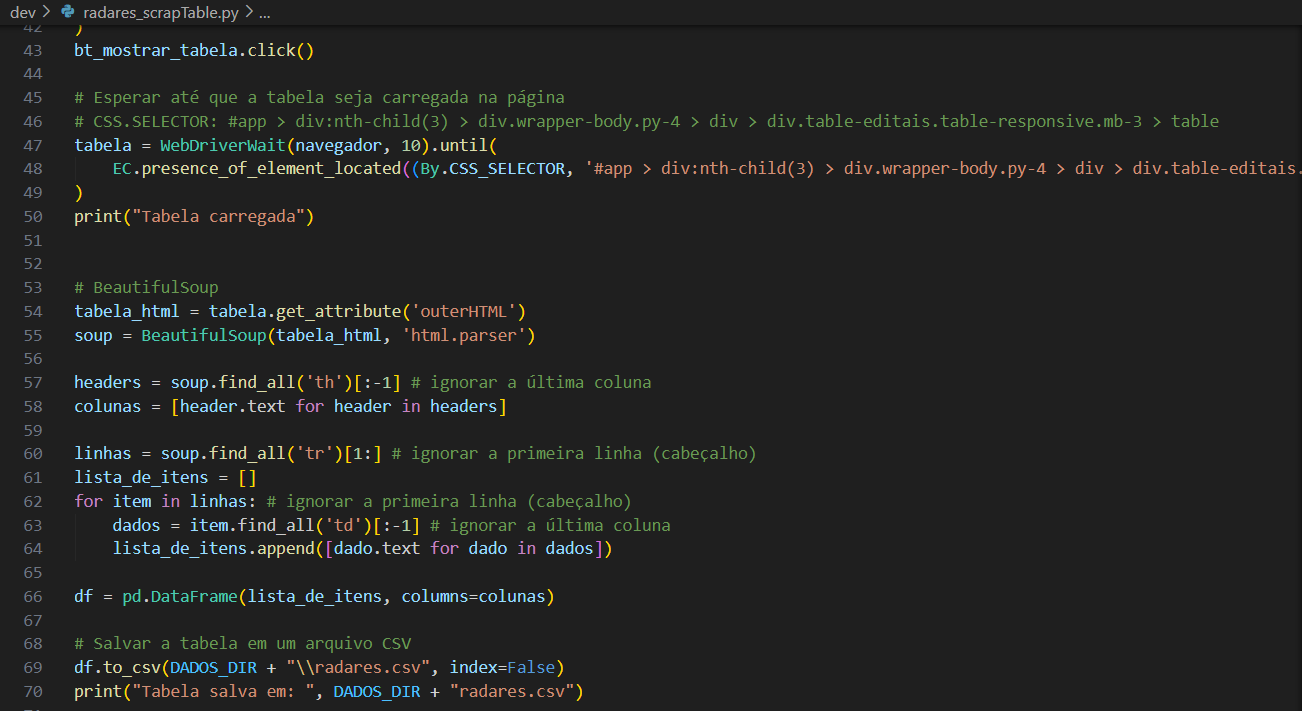

In [ ]:
# Carregando dataset de radares (DNIT)
  # encoding 'utf-8' para suportar dados com acentuação
  # separador ','
  # dtype 'Rodovia' setado como 'str' (evitar conversão automática para float)
radares = pd.read_csv(pathUtil + "radaresDNIT.csv", encoding='utf-8', sep=',', dtype={'Rodovia':str})

pd.set_option('display.max_columns', None)
display(radares.head())
print(radares.shape)

,Código do Equipamento,Equipamento,UF,Município,Rodovia,Km,Coordenadas,Registro INMETRO,Nº de Série
0,ROB20040023,Redutor Eletrônico de Velocidade,RO,PORTO VELHO,364,"712,585","-63.87748, -8.77459",12908470,FLICD2005A00558
1,ROR20040020,Controlador Eletrônico de Velocidade,RO,PORTO VELHO,364,"714,250","-63.889707, -8.777642",12908471,FLISD2005A00554
2,ROB20040024,Redutor Eletrônico de Velocidade,RO,PORTO VELHO,364,"800,680","-64.404046, -9.258233",4781728,FLICD2005A00555
3,ROB21120033,Redutor Eletrônico de Velocidade,RO,PORTO VELHO,319,"61,065","-63.889548, -8.741321",14826018,FLICD2106A00572
4,ROR20050023,Controlador Eletrônico de Velocidade,RO,PORTO VELHO,364,"703,380","-63.803277, -8.800411",12908465,FLISD2005A00529


(1795, 9)


# PRÉ-PROCESSAMENTO

## Dataset 'radares'

> O pré-processamento do dataset '`radares`' é simplificado, para posteriormente se obter a informação sobre quantitativo de radares nas proximidades de cada acidente e incluí-la no dataset 'ocorrencias'.

- Checagem de dados nulos
- Tipagem dos dados
- Formatação dos campos 'Rodovia' e 'Km'
- Outliers: Eliminação de duplicatas e dados irrelevantes

In [ ]:
# Verificação de instâncias nulas
radares.isnull().sum()

Código do Equipamento    0
Equipamento              0
UF                       0
Município                0
Rodovia                  0
Km                       0
Coordenadas              0
Registro INMETRO         0
Nº de Série              0
dtype: int64

In [ ]:
# Tipos dos dados
radares.dtypes

Código do Equipamento    object
Equipamento              object
UF                       object
Município                object
Rodovia                  object
Km                       object
Coordenadas              object
Registro INMETRO         object
Nº de Série              object
dtype: object

In [ ]:
# Verificando formatação das BRs
print(f"BRs com formatação incorreta: {len(radares[radares['Rodovia'].apply(len) < 3])}\n")

# converter coluna KM para float
radares['Km'] = radares['Km'].apply(str_to_float)

# resumo
radares.info()

BRs com formatação incorreta: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Código do Equipamento  1795 non-null   object 
 1   Equipamento            1795 non-null   object 
 2   UF                     1795 non-null   object 
 3   Município              1795 non-null   object 
 4   Rodovia                1795 non-null   object 
 5   Km                     1795 non-null   float64
 6   Coordenadas            1795 non-null   object 
 7   Registro INMETRO       1795 non-null   object 
 8   Nº de Série            1795 non-null   object 
dtypes: float64(1), object(8)
memory usage: 126.3+ KB


###**Outliers**

- Duplicatas

Vamos considerar que são duplicatas as instâncias com mesma 'Coordenadas' ou com mesma ['UF', 'Rodovia' e 'Km'].
Normalmente uma mesma estrutura da radar monitora várias faixas e sentidos da via. Nos registros do DNIT, cada faixa/sentido monitorado em determinado ponto, consta como se fosse um equipamento independente, quando na verdade todo o conjunto se trata de uma estrutura única.

In [ ]:
# quantidade de instâncias
len(radares)

1795

In [ ]:
# Duplicatas (segundo 'Coordenadas')
radares[radares.duplicated(subset=['Coordenadas'], keep=False)]

,Código do Equipamento,Equipamento,UF,Município,Rodovia,Km,Coordenadas,Registro INMETRO,Nº de Série
76,PBB18120030,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,444.950,"-38.07558, -6.78689",14363789,FSC110-0332
77,PBB18120031,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,444.950,"-38.07558, -6.78689",14363790,FSC110-0333
78,PBB18120024,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,445.950,"-38.085274, -6.785988",14363791,FSC110-0328
79,PBB18120025,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,445.950,"-38.085274, -6.785988",14363792,FSC110-0329
80,PBB18120026,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,445.450,"-38.08063, -6.787037",14363787,FSC110-0330
...,...,...,...,...,...,...,...,...,...
1681,MSS19100006,Controlador Eletrônico Misto,MS,TRES LAGOAS,262,7.881,"-51.683427, -20.798855",FISCALTECH,FSCII-6772
1682,MSS19100007,Controlador Eletrônico Misto,MS,TRES LAGOAS,262,7.859,"-51.683427, -20.798855",FISCALTECH,FSCII-6774
1683,MSS19100008,Controlador Eletrônico Misto,MS,TRES LAGOAS,262,7.835,"-51.683427, -20.798855",FISCALTECH,FSCII-6773
1724,GOR22060038,Controlador Eletrônico de Velocidade,GO,MINEIROS,364,302.170,"-52.533325, -17.531144",13871423,FLISD2002A00449


In [ ]:
# Duplicatas (segundo uf, rodovia e km)
radares[radares.duplicated(subset =['UF', 'Rodovia', 'Km'], keep = False)]

,Código do Equipamento,Equipamento,UF,Município,Rodovia,Km,Coordenadas,Registro INMETRO,Nº de Série
52,GOR20020014,Controlador Eletrônico de Velocidade,GO,SANTO ANTONIO DA BARRA,060,342.80,"-50.635733, -17.561974",11786721,FLISD2003A00491
53,GOR24040045,Controlador Eletrônico de Velocidade,GO,SANTO ANTONIO DA BARRA,060,342.80,"-50.635769, -17.561783",EBG5247303,FLISD0424A00789
76,PBB18120030,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,444.95,"-38.07558, -6.78689",14363789,FSC110-0332
77,PBB18120031,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,444.95,"-38.07558, -6.78689",14363790,FSC110-0333
78,PBB18120024,Redutor Eletrônico de Velocidade,PB,APARECIDA,230,445.95,"-38.085274, -6.785988",14363791,FSC110-0328
...,...,...,...,...,...,...,...,...,...
1520,RSB20120399,Redutor Eletrônico de Velocidade,RS,SANTA MARIA,158,325.30,"-53.79749, -29.70547",14445164,11402
1561,RSB21020404,Redutor Eletrônico de Velocidade,RS,SAO MARTINHO,468,63.77,"-53.82315, -27.760583",14445415,11463
1562,RSB21020405,Redutor Eletrônico de Velocidade,RS,SAO MARTINHO,468,63.77,"-53.82315, -27.760583",14445414,11462
1663,MSB23100013,Redutor Eletrônico de Velocidade,MS,PONTA PORA,463,107.15,"-55.674631, -22.589907",FISCALTECH,FSCII-6920


In [ ]:
# Eliminando duplicatas
# Eliminando duplicatas
#radares.drop_duplicates(subset =['Coordenadas'], keep = False, inplace = True)
radares.drop_duplicates(subset =['UF', 'Rodovia', 'Km'], keep = False, inplace = True)
radares.reset_index(drop= True, inplace= True)
print(f"Radares: {len(radares)}")   # Tamanho após eliminação
radares.tail()

Radares: 1591


,Código do Equipamento,Equipamento,UF,Município,Rodovia,Km,Coordenadas,Registro INMETRO,Nº de Série
1586,MTB19090006,Redutor Eletrônico de Velocidade,MT,PRIMAVERA DO LESTE,070,281.070,"-54.305769, -15.5674",13971739,11099
1587,MTB19090007,Redutor Eletrônico de Velocidade,MT,PRIMAVERA DO LESTE,070,282.435,"-54.317054, -15.573105",13971737,11069
1588,MTB19100035,Redutor Eletrônico de Velocidade,MT,PRIMAVERA DO LESTE,070,284.300,"-54.333267, -15.574498",13971770,11024
1589,SCB20110124,Redutor Eletrônico de Velocidade,SC,APIUNA,470,99.140,"-49.39638, -27.041602",14794085,6068
1590,SCB20100121,Redutor Eletrônico de Velocidade,SC,APIUNA,470,97.440,"-49.38398, -27.031218",14743398,6066


In [ ]:
# Verificar se há codigos de equipamentos duplicados
radares[radares.duplicated(subset=['Código do Equipamento'], keep=False)]

,Código do Equipamento,Equipamento,UF,Município,Rodovia,Km,Coordenadas,Registro INMETRO,Nº de Série


Para calcular os radares nas proximidades dos acidentes, vamos precisar dos campos 'UF', 'Rodovia' e 'Km'. Vamos manter também o campo 'Código do Equipamento' para identificação.

In [ ]:
# Eliminar colunas irrelevantes
radares.drop(['Equipamento', 'Município', 'Registro INMETRO', 'Nº de Série', 'Coordenadas'], axis=1, inplace=True)
radares.tail()

,Código do Equipamento,UF,Rodovia,Km
1586,MTB19090006,MT,070,281.070
1587,MTB19090007,MT,070,282.435
1588,MTB19100035,MT,070,284.300
1589,SCB20110124,SC,470,99.140
1590,SCB20100121,SC,470,97.440


In [ ]:
# Index
radares.index

RangeIndex(start=0, stop=1591, step=1)

<Axes: >

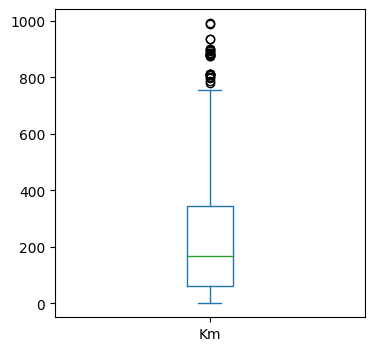

In [ ]:
# Vizualizar boxplot
radares['Km'].plot(kind='box', figsize=(4,4))

## Dataset 'ocorrencias'

> O pré-processamento do dataset 'ocorrencias' é mais aprofundado, envolvendo mais procedimentos.

- Tratamento de instâncias nulas e dados faltantes (eliminação/imputação de valores)
- Tipagem dos dados
- Ajuste/criação de colunas
- Agregamento de informações de radares
- Normalização
- Discretização
- Outliers




---
AJUSTE:
Executar este código para tratar o dataset ampliado (2017 a 2023)


In [ ]:
ocorrencias = ocorrencias_amp.copy()
envolvidos = envolvidos_amp.copy()

### Instâncias nulas

 - BRs: Serão removidas as instâncias com BRs nulas, pois são acidentes fora de rodovias federais, não incluídos no escopo do estudo.

In [ ]:
# Checar se ambos os datasets têm 'id's e dados compatíveis (são os mesmos acidentes)
envolvidos_cleaned_sorted = envolvidos.drop_duplicates(subset=['id']).sort_values('id').reset_index(drop=True)
ocorrencias_sorted = ocorrencias.sort_values('id').reset_index(drop=True)
print(f"Mesmo id: {(envolvidos_cleaned_sorted['id'] == ocorrencias_sorted['id']).all()}")
print(f"Mesma data: {(envolvidos_cleaned_sorted['data_inversa'] == ocorrencias_sorted['data_inversa']).all()}")
print(f"Mesma latitude: {(envolvidos_cleaned_sorted['latitude'] == ocorrencias_sorted['latitude']).all()}")
print(f"Mesma longitude: {(envolvidos_cleaned_sorted['longitude'] == ocorrencias_sorted['longitude']).all()}")

Mesmo id: True
Mesma data: True
Mesma latitude: True
Mesma longitude: True


In [ ]:
# Quantidade de instâncias com BRs nulas
ocorrencias.isnull().sum()['br']

37

In [ ]:
# Eliminando instâncias nulas (BRs)
ids_br_null = ocorrencias.loc[ocorrencias['br'].isnull(), 'id'] # pegar ids das ocorrências com BRs nulas

ocorrencias.dropna(subset='br', inplace=True)
envolvidos = envolvidos[~envolvidos['id'].isin(ids_br_null)]
ocorrencias.reset_index(inplace=True, drop=True)
envolvidos.reset_index(inplace=True, drop=True)

In [ ]:
# Checando indices
print(ocorrencias.index)
print(envolvidos.index)

RangeIndex(start=0, stop=19726, step=1)
RangeIndex(start=0, stop=47243, step=1)


In [ ]:
# Eliminar colunas desnecessárias em envolvidos
envolvidos.drop(envolvidos.columns[26:], axis=1, inplace=True)
envolvidos.drop(envolvidos.columns[1:18], axis=1, inplace=True)
envolvidos.drop('estado_fisico', axis=1, inplace=True)

In [ ]:
display(ocorrencias.head(2))
display(envolvidos.head(2))

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,192,2017-01-01,domingo,15:55:00,PE,101,"62,8",RECIFE,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,0,1,1,1,1,2,"-8,007427","-34,937846",SPRF-PE,DEL01-PE,UOP02-DEL01-PE
1,317,2017-01-01,domingo,22:00:00,PE,232,142,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,"-8,32660726","-36,11564465",SPRF-PE,DEL02-PE,UOP03-DEL02-PE


,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo
0,192,161,Caminhão,I/M.BENZ 415 MARIMAR AMB/M.BENZ 415 MARIMAR AM...,2013.0,Condutor,35.0,Masculino
1,317,340,Caminhão,VW/24.250 CLC 6X2/24.250 CLC 6X2/24.250 CLC 6X2,2007.0,Condutor,0.0,Masculino


In [ ]:
ocorrencias.isnull().sum()

id                        0
data_inversa              0
dia_semana                0
horario                   0
uf                        0
br                        0
km                        0
municipio                 0
causa_acidente            0
tipo_acidente             1
classificacao_acidente    0
fase_dia                  0
sentido_via               0
condicao_metereologica    0
tipo_pista                0
tracado_via               0
uso_solo                  0
pessoas                   0
mortos                    0
feridos_leves             0
feridos_graves            0
ilesos                    0
ignorados                 0
feridos                   0
veiculos                  0
latitude                  0
longitude                 0
regional                  0
delegacia                 2
uop                       4
dtype: int64

In [ ]:
# Eliminar instância com 'tipo_acidente' nulo
# Eliminando instâncias nulas (BRs)
ids_del = ocorrencias.loc[ocorrencias['tipo_acidente'].isnull(), 'id']

ocorrencias.dropna(subset='tipo_acidente', inplace=True)
envolvidos.drop(envolvidos[envolvidos['id'].isin(ids_del)].index, inplace=True)
ocorrencias.reset_index(inplace=True, drop=True)
envolvidos.reset_index(inplace=True, drop=True)

In [ ]:
ocorrencias[ocorrencias['tipo_acidente'].isnull()]

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop


### Tipagem dos dados e ajustes de colunas

- BRs: Correção para o formato "###"

- Data e Hora: Colunas reajustadas, criação de novos atributos temporais (ano, mes)

- Tipos categóricos e numéricos: Ajustados.

In [ ]:
# Verificar tipos dos dados
envolvidos.dtypes

id                          int64
id_veiculo                  int64
tipo_veiculo               object
marca                      object
ano_fabricacao_veiculo    float64
tipo_envolvido             object
idade                     float64
sexo                       object
dtype: object

In [ ]:
# Verificar tipos dos dados
ocorrencias.dtypes

id                         int64
data_inversa              object
dia_semana                object
horario                   object
uf                        object
br                        object
km                        object
municipio                 object
causa_acidente            object
tipo_acidente             object
classificacao_acidente    object
fase_dia                  object
sentido_via               object
condicao_metereologica    object
tipo_pista                object
tracado_via               object
uso_solo                  object
pessoas                    int64
mortos                     int64
feridos_leves              int64
feridos_graves             int64
ilesos                     int64
ignorados                  int64
feridos                    int64
veiculos                   int64
latitude                  object
longitude                 object
regional                  object
delegacia                 object
uop                       object
dtype: obj

In [ ]:
# Verificando formatação das BRs (Formato correto: '###')
print(f"BRs com formatação incorreta: {len(ocorrencias[ocorrencias['br'].apply(len) < 3])}")

BRs com formatação incorreta: 8


In [ ]:
ocorrencias[ocorrencias['br'].apply(len) < 3]

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
409,51192,2017-07-03,segunda-feira,04:30:00,PE,0,0,GRAVATA,Condutor Dormindo,Capotamento,Com Vítimas Fatais,Amanhecer,Não Informado,Chuva,Dupla,Declive,Não,2,2,0,0,0,0,0,1,"-8,173185","-35,456845",SPRF-PE,DEL01-PE,UOP02-DEL02PE
3571,115719,2018-03-04,domingo,04:00:00,PE,0,0,BELEM DE SAO FRANCISCO,Defeito na Via,Tombamento,Sem Vítimas,Plena Noite,Não Informado,Céu Claro,Simples,Reta,Não,1,0,0,0,1,0,0,1,"-8,61457","-39,240139",SPRF-PE,DEL05-PE,UOP03-DEL05-PE
3944,164653,2018-10-10,quarta-feira,12:55:00,PE,0,0,CARUARU,Falta de Atenção à Condução,Colisão com objeto estático,Sem Vítimas,Pleno dia,Não Informado,Sol,Dupla,Reta,Não,2,0,0,0,1,1,0,2,"-8,30581685","-35,96351445",SPRF-PE,DEL02-PE,NaN
4452,113324,2018-02-23,sexta-feira,00:00:00,PE,0,0,RECIFE,Defeito na Via,Danos eventuais,Sem Vítimas,Pleno dia,Não Informado,Ignorado,Simples,Reta,Não,1,0,0,0,1,0,0,1,"-8,0847885","-34,886531",SPRF-PE,NaN,NaN
4580,118646,2018-03-16,sexta-feira,12:35:00,PE,0,0,PETROLINA,Falta de Atenção à Condução,Colisão lateral,Com Vítimas Feridas,Pleno dia,Não Informado,Céu Claro,Simples,Reta,Sim,2,0,1,0,1,0,1,2,"-9,33118648","-40,56289673",SPRF-PE,DEL06-PE,UOP01-DEL06-PE
4651,121501,2018-02-09,sexta-feira,08:00:00,PE,0,0,RECIFE,Defeito na Via,Danos eventuais,Sem Vítimas,Plena Noite,Não Informado,Ignorado,Dupla,Reta,Não,1,0,0,0,1,0,0,1,"-8,08267069","-34,88876038",SPRF-PE,NaN,NaN
5376,153352,2018-08-16,quinta-feira,10:45:00,PE,0,0,CARPINA,Velocidade Incompatível,Colisão com objeto estático,Com Vítimas Feridas,Pleno dia,Não Informado,Sol,Simples,Reta,Sim,2,0,1,0,1,0,1,2,"-7,839701","-35,234454",SPRF-PE,DEL01-PE,NaN
6136,186933,2018-09-25,terça-feira,18:30:00,PE,0,0,PETROLINA,Restrição de Visibilidade,Colisão traseira,Sem Vítimas,Anoitecer,Não Informado,Nublado,Simples,Reta,Não,2,0,0,0,1,1,0,2,"-9,31899019","-40,54332733",SPRF-PE,DEL06-PE,UOP01-DEL06-PE


In [ ]:
# Eliminar essas ocorrências (dados inconsistentes)
ids_del = ocorrencias.loc[(ocorrencias['br'].apply(len) < 3), 'id'] # pegar ids das ocorrências com BRs nulas

ocorrencias.drop(ocorrencias[ocorrencias['id'].isin(ids_del)].index, inplace=True)
envolvidos.drop(envolvidos[envolvidos['id'].isin(ids_del)].index, inplace=True)
ocorrencias.reset_index(inplace=True, drop=True)
envolvidos.reset_index(inplace=True, drop=True)

In [ ]:
envolvidos_cleaned_sorted = envolvidos.drop_duplicates(subset=['id']).sort_values('id').reset_index(drop=True)
ocorrencias_sorted = ocorrencias.sort_values('id').reset_index(drop=True)
print(f"Mesmo id: {(envolvidos_cleaned_sorted['id'] == ocorrencias_sorted['id']).all()}")

Mesmo id: True


In [ ]:
# Categóricos com ordem específica
categorias_ordenadas = ['dia_semana', 'classificacao_acidente', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'uso_solo']

# Lista das categorias específicas para cada coluna categórica
lista_categorias = [
    ['zero', 'domingo', 'segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado'],
    ['Sem Vítimas', 'Com Vítimas Feridas', 'Com Vítimas Fatais'],
    ['Amanhecer', 'Pleno dia', 'Anoitecer', 'Plena Noite'],
    ['Decrescente', 'Crescente'],
    ['Ignorado', 'Céu Claro', 'Sol', 'Vento', 'Nublado', 'Garoa/Chuvisco', 'Chuva', 'Nevoeiro/Neblina', 'Neve'],
    ['Simples', 'Dupla', 'Múltipla'],
    ['Não', 'Sim']
]

# Converter cada coluna categórica para o tipo categórico com ordem específica
for coluna, categoria in zip(categorias_ordenadas, lista_categorias):
    dtype = CategoricalDtype(categories=categoria, ordered=True)
    ocorrencias[coluna] = ocorrencias[coluna].astype(dtype)

In [ ]:
ocorrencias['dia_semana'].cat.codes.describe()

count    19717.000000
mean         4.001014
std          2.079057
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max          7.000000
dtype: float64

In [ ]:
# Conversão de tipos

# Categóricos (restante)
categoricos_ocorrencias = ['uf', 'br', 'municipio', 'causa_acidente', 'tipo_acidente', 'tracado_via', 'regional', 'delegacia', 'uop']
categoricos_envolvidos = ['tipo_veiculo', 'marca', 'tipo_envolvido', 'sexo']

ocorrencias[categoricos_ocorrencias] = ocorrencias[categoricos_ocorrencias].astype('category')
envolvidos[categoricos_envolvidos] = envolvidos[categoricos_envolvidos].astype('category')

# Numéricos (com conversão de string para float)
ocorrencias[['km', 'latitude', 'longitude']] = ocorrencias[['km', 'latitude', 'longitude']].applymap(str_to_float)

In [ ]:
# Data/hora

# Nova coluna datetime
ocorrencias ['data_hora'] = pd.to_datetime(ocorrencias['data_inversa'] + " " + ocorrencias['horario'])

# Ano, mês, dia e hora (float)
ocorrencias['ano'] = ocorrencias['data_inversa'].str.slice(0, 4).astype('int')
ocorrencias['mes'] = ocorrencias['data_inversa'].str.slice(5, 7).astype('int')
ocorrencias['trimestre'] = ocorrencias['mes'].apply(lambda x: (x-1)//3 + 1).astype('int') # divide o mês em grupos de 3 e ajusta para começar do trimestre 1
ocorrencias['dia'] = ocorrencias['data_inversa'].str.slice(8, 10).astype('int')
ocorrencias['hora'] = ocorrencias['horario'].apply(hora_to_float) # float
#ocorrencias['dia_semana_int'] = ocorrencias['dia_semana'].apply(dia_semana_to_int)

# Distretizar 'hora' com 4 bins: cada um corresponderá a um período do dia (Madrugada, Manhã, Tarde e Noite)
ocorrencias['periodo_dia'] = pd.cut(ocorrencias['hora'], 4, labels=['Madrugada', 'Manhã', 'Tarde', 'Noite'])
categoricos_ocorrencias.append('periodo_dia') # Atualizar lista de categóricos

# Descartar
ocorrencias.drop(['data_inversa', 'horario'], axis=1, inplace=True)

# Reordenar colunas
ocorrencias = ocorrencias[['id', 'data_hora', 'ano', 'mes', 'dia', 'trimestre', 'hora', 'periodo_dia'] + list(ocorrencias.columns)[1:-7]]

In [ ]:
display(ocorrencias.tail(2))
display(envolvidos.tail(2))

,id,data_hora,ano,mes,dia,trimestre,hora,periodo_dia,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
19715,582026,2023-10-28 12:55:00,2023,10,28,4,12.916667,Tarde,sábado,PE,104,77.0,AGRESTINA,Mal súbito do condutor,Colisão frontal,Com Vítimas Fatais,Pleno dia,Crescente,Céu Claro,Simples,Declive;Curva,Não,10,1,6,1,2,0,7,4,-8.375978,-35.983662,SPRF-PE,DEL02-PE,UOP01-DEL02-PE
19716,586766,2023-12-30 11:30:00,2023,12,30,4,11.500000,Manhã,sábado,PE,101,85.0,JABOATAO DOS GUARARAPES,Condutor deixou de manter distância do veículo...,Engavetamento,Sem Vítimas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Não,3,0,0,0,3,0,0,3,-8.180656,-34.959653,SPRF-PE,DEL01-PE,UOP01-DEL01-PE


,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo
47139,586766,1046262,Automóvel,GM/CORSA WIND,1997.0,Condutor,NaN,Masculino
47140,586766,1046257,Caminhonete,MMC/L200 TRITON SPO GL,2021.0,Condutor,NaN,Masculino


In [ ]:
# Resumo dos dados pós conversões
print(ocorrencias.info())
envolvidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19717 entries, 0 to 19716
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      19717 non-null  int64         
 1   data_hora               19717 non-null  datetime64[ns]
 2   ano                     19717 non-null  int64         
 3   mes                     19717 non-null  int64         
 4   dia                     19717 non-null  int64         
 5   trimestre               19717 non-null  int64         
 6   hora                    19717 non-null  float64       
 7   periodo_dia             19717 non-null  category      
 8   dia_semana              19717 non-null  category      
 9   uf                      19717 non-null  category      
 10  br                      19717 non-null  category      
 11  km                      19717 non-null  float64       
 12  municipio               19717 non-null  catego

### Tipo Veiculo

In [ ]:
envolvidos.tipo_veiculo.cat.categories

Index(['Automóvel', 'Bicicleta', 'Caminhonete', 'Caminhão', 'Caminhão-trator',
       'Camioneta', 'Carro de mão', 'Carroça-charrete', 'Ciclomotor',
       'Micro-ônibus', 'Motocicleta', 'Motoneta', 'Não Informado',
       'Não se aplica', 'Outros', 'Quadriciclo', 'Reboque', 'Semireboque',
       'Trator de rodas', 'Triciclo', 'Utilitário', 'Ônibus'],
      dtype='object')

In [ ]:
indices_imputar = envolvidos[(envolvidos.tipo_veiculo == 'Não Informado')].index

In [ ]:
envolvidos[(envolvidos['tipo_veiculo'] != 'Não Informado') & (~envolvidos['marca'].isnull())]

,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo
0,192,161,Caminhão,I/M.BENZ 415 MARIMAR AMB/M.BENZ 415 MARIMAR AM...,2013.0,Condutor,35.0,Masculino
1,317,340,Caminhão,VW/24.250 CLC 6X2/24.250 CLC 6X2/24.250 CLC 6X2,2007.0,Condutor,0.0,Masculino
2,319,366,Caminhão,M.BENZ/710/710/710,2000.0,Condutor,36.0,Masculino
3,369,529,Caminhão,FORD/F250 XL F22/F250 XL F22/F250 XL F22,2007.0,Condutor,37.0,Masculino
4,369,528,Caminhão,VW/8.150 E DELIVERY PLUS/8.150 E DELIVERY PLUS...,2011.0,Condutor,27.0,Masculino
...,...,...,...,...,...,...,...,...
47136,582026,1037539,Automóvel,VW/POLO 1.6,2003.0,Condutor,35.0,Masculino
47137,582026,1037538,Micro-ônibus,FIAT/DUCATO MINIBUS,2008.0,Passageiro,42.0,Feminino
47138,586766,1046263,Automóvel,FIAT/PALIO FIRE,2016.0,Condutor,NaN,Masculino
47139,586766,1046262,Automóvel,GM/CORSA WIND,1997.0,Condutor,NaN,Masculino


In [ ]:
envolvidos[(envolvidos.tipo_veiculo == 'Não Informado') & envolvidos.marca.isnull()]

,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo
37803,473347,829339,Não Informado,NaN,NaN,Condutor,NaN,Não Informado
38563,482171,845723,Não Informado,NaN,NaN,Condutor,NaN,Não Informado
39494,492892,866092,Não Informado,NaN,NaN,Condutor,NaN,Não Informado
41929,511051,900726,Não Informado,NaN,NaN,Condutor,NaN,Não Informado
44908,548421,973159,Não Informado,NaN,NaN,Condutor,NaN,Não Informado


In [ ]:
# 1. Analisar a distribuição de 'tipo_veiculo' para cada 'marca'
distribuicao_por_marca = envolvidos[(envolvidos['tipo_veiculo'] != 'Não Informado') & (~envolvidos['marca'].isnull())].groupby('marca')['tipo_veiculo'].agg(
    lambda x: x.value_counts().index[0])
print(distribuicao_por_marca)

# 2. Criar um mapeamento de marca para tipo de veículo mais comum
mapa_marca_tipo = distribuicao_por_marca.to_dict()

# 3. Função para imputar os valores "Não Informado"
def imputar_tipo_veiculo(row):
    if row['tipo_veiculo'] == 'Não Informado':
        return mapa_marca_tipo.get(row['marca'], 'Não Informado')
    return row['tipo_veiculo']

# 4. Aplicar o mapeamento para imputar os valores
envolvidos['tipo_veiculo'] = envolvidos.apply(imputar_tipo_veiculo, axis=1)

# Verificar as primeiras linhas do DataFrame resultante
print(envolvidos[['marca', 'tipo_veiculo']].head())

marca
AGRALE/6000 D/6000 D/6000 D                                  Caminhão
AGRALE/7000D RD/7000D RD/7000D RD                            Caminhão
AGRALE/9200 TCA/9200 TCA/9200 TCA                            Caminhão
AGRALE/COMIL PIA O                                             Ônibus
AGRALE/COMIL PIA O/COMIL PIA O/COMIL PIA O                     Ônibus
                                                             ...     
YAMAHA/YS150 FAZER ED/YS150 FAZER ED/YS150 FAZER ED       Motocicleta
YAMAHA/YS150 FAZER SED                                    Motocicleta
YAMAHA/YS150 FAZER SED/YS150 FAZER SED/YS150 FAZER SED    Motocicleta
YAMAHA/YZF R3 ABS                                         Motocicleta
YAMAHA/YZF R3 MONSTER                                     Motocicleta
Name: tipo_veiculo, Length: 4759, dtype: object
                                               marca tipo_veiculo
0  I/M.BENZ 415 MARIMAR AMB/M.BENZ 415 MARIMAR AM...     Caminhão
1    VW/24.250 CLC 6X2/24.250 CLC 6X2/24.250

In [ ]:
display(envolvidos.loc[indices_imputar, ['marca', 'tipo_veiculo']])
envolvidos[(envolvidos['tipo_veiculo'] == 'Não Informado')]

,marca,tipo_veiculo
3860,FIAT/DOBLO PERKONS.CH/DOBLO PERKONS.CH/DOBLO P...,Automóvel
34808,FORD/ECOSPORT XLT 1.6L,Camioneta
34844,I/CHEV TRACKER PREMIER,Camioneta
35406,RENAULT/DUSTER DYN16 SCE,Camioneta
35407,RENAULT/DUSTER DYN16 SCE,Camioneta
...,...,...
47100,RENAULT/DUSTER INT16 CVT,Automóvel
47109,JEEP/RENEGADE SPORT MT,Camioneta
47110,JEEP/RENEGADE SPORT MT,Camioneta
47111,JEEP/RENEGADE SPORT MT,Camioneta


,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo
37803,473347,829339,Não Informado,NaN,NaN,Condutor,NaN,Não Informado
38563,482171,845723,Não Informado,NaN,NaN,Condutor,NaN,Não Informado
39494,492892,866092,Não Informado,NaN,NaN,Condutor,NaN,Não Informado
41929,511051,900726,Não Informado,NaN,NaN,Condutor,NaN,Não Informado
44908,548421,973159,Não Informado,NaN,NaN,Condutor,NaN,Não Informado


In [ ]:
map_tipo_veiculo = {
    'automoveis': ['Automóvel', 'Camioneta', 'Utilitário', 'Caminhonete'],
    'caminhoes': ['Caminhão', 'Caminhão-trator'],
    'reboques': ['Reboque', 'Semireboque'],
    'motocicletas': ['Motocicleta', 'Motoneta', 'Ciclomotor', 'Triciclo', 'Quadriciclo'],
    'onibus': ['Ônibus', 'Micro-ônibus'],
    'nao_motorizados': ['Bicicleta', 'Carro de mão', 'Carroça-charrete'],
    'agricolas': ['Trator de rodas'],
    'veiculos_ignorados': ['Outros', 'Não Informado'],
    'sem_veiculo': ['Não se aplica']
}

# Inverter o mapeamento para facilitar a substituição
map_inverso = {}
for grupo, tipos in map_tipo_veiculo.items():
    for tipo in tipos:
        map_inverso[tipo] = grupo

map_tipo_veiculo = map_inverso

In [ ]:
# Função para mapear o tipo de veículo ao grupo correspondente
def mapear_grupo(tipo):
    return map_tipo_veiculo.get(tipo, 'Outros') #retorna 'Outros' para tipos não mapeados

# Preencher valores NaN em 'tipo_veiculo' com 'Outros'
#envolvidos['tipo_veiculo'] = envolvidos['tipo_veiculo'].fillna('Outros')

# Aplicar o mapeamento para criar a nova coluna 'grupo_veiculo'
envolvidos['grupo_veiculo'] = envolvidos['tipo_veiculo'].apply(mapear_grupo)

# Verificar as primeiras linhas do DataFrame resultante
print(envolvidos[['tipo_veiculo', 'grupo_veiculo']].tail(10))

       tipo_veiculo grupo_veiculo
47131     Automóvel    automoveis
47132     Automóvel    automoveis
47133  Micro-ônibus        onibus
47134     Automóvel    automoveis
47135     Automóvel    automoveis
47136     Automóvel    automoveis
47137  Micro-ônibus        onibus
47138     Automóvel    automoveis
47139     Automóvel    automoveis
47140   Caminhonete    automoveis


erros no dataset para o atributo 'veiculo'
- em acidentes com registros com envolvidos do tipo pedestres, testemunhas ou cavaleiro, estas são vinculadas a um veiculo de id 0, e tipo 'Não se aplica'.
Esses veículos 'inexistentes' são contabilzados no atributo 'veiculos'

In [ ]:
# Criar uma tabela de quantitativos para cada grupo de veículos em cada acidente
grupos_veiculos = envolvidos[envolvidos['tipo_envolvido'] != 'Passageiro'].groupby(['id', 'grupo_veiculo']).size().unstack(fill_value=0)
grupos_veiculos['sem_veiculo'] = grupos_veiculos['sem_veiculo'].apply((lambda x: 1 if x > 0 else 0))
#grupos_veiculos = grupos_veiculos.applymap(lambda x: 1 if x > 0 else 0) # 0 ou 1
#grupos_veiculos.drop('sem_veiculo', axis=1, inplace=True)

In [ ]:
grupos_veiculos.head()

grupo_veiculo,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,sem_veiculo,veiculos_ignorados
id,,,,,,,,,,
19,0,0,1,0,1,0,0,0,0,0
88,0,0,2,0,0,0,0,0,0,0
141,0,0,1,0,0,0,0,0,0,0
157,0,0,1,0,0,0,0,0,0,0
192,2,0,0,1,0,0,0,0,0,0


In [ ]:
print(len(grupos_veiculos))
print(len(ocorrencias))

19717
19717


In [ ]:
# Unir a tabela de veículos com o DataFrame 'ocorrencias'
ocorrencias = ocorrencias.merge(grupos_veiculos, how='left', left_on='id', right_index=True)
ocorrencias

,id,data_hora,ano,mes,dia,trimestre,hora,periodo_dia,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,sem_veiculo,veiculos_ignorados
0,192,2017-01-01 15:55:00,2017,1,1,1,15.916667,Tarde,domingo,PE,101,62.8,RECIFE,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,0,1,1,1,1,2,-8.007427,-34.937846,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,2,0,0,1,0,0,0,0,0,0
1,317,2017-01-01 22:00:00,2017,1,1,1,22.000000,Noite,domingo,PE,232,142.0,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-8.326607,-36.115645,SPRF-PE,DEL02-PE,UOP03-DEL02-PE,0,0,0,1,0,0,1,0,0,0
2,319,2017-01-01 21:30:00,2017,1,1,1,21.500000,Noite,domingo,PE,232,84.7,GRAVATA,Animais na Pista,Atropelamento de Animal,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,1,0,0,0,1,0,0,1,-8.215031,-35.635721,SPRF-PE,DEL01-PE,UOP02-DEL02PE,0,0,0,1,0,0,0,0,0,0
3,369,2017-01-02 06:30:00,2017,1,2,1,6.500000,Manhã,segunda-feira,PE,101,23.0,GOIANA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-7.684500,-34.923700,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,0,0,0,2,0,0,0,0,0,0
4,483,2017-01-02 13:50:00,2017,1,2,1,13.833333,Tarde,segunda-feira,PE,101,73.2,RECIFE,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Pleno dia,Decrescente,Céu Claro,Dupla,Curva,Sim,3,0,0,0,3,0,0,2,-8.096529,-34.949602,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19712,576999,2023-12-26 16:30:00,2023,12,26,4,16.500000,Tarde,terça-feira,PE,101,207.0,XEXEU,Reação tardia ou ineficiente do condutor,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,1,1,0,1,2,-8.814059,-35.633737,SPRF-PE,DEL01-PE,UOP03-DEL01-PE,0,0,1,0,0,0,0,0,1,0
19713,578174,2023-12-18 09:30:00,2023,12,18,4,9.500000,Manhã,segunda-feira,PE,101,67.0,RECIFE,Condutor deixou de manter distância do veículo...,Engavetamento,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,1,0,0,2,1,3,-8.042435,-34.943281,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,0,0,3,0,0,0,0,0,0,0
19714,578195,2023-11-17 10:51:00,2023,11,17,4,10.850000,Manhã,sexta-feira,PE,232,410.5,SERRA TALHADA,Acessar a via sem observar a presença dos outr...,Colisão transversal,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Curva,Sim,3,0,2,0,1,0,2,2,-7.982618,-38.300396,SPRF-PE,DEL04-PE,UOP01-DEL04-PE,0,0,1,0,1,0,0,0,0,0
19715,582026,2023-10-28 12:55:00,2023,10,28,4,12.916667,Tarde,sábado,PE,104,77.0,AGRESTINA,Mal súbito do condutor,Colisão frontal,Com Vítimas Fatais,Pleno dia,Crescente,Céu Claro,Simples,Declive;Curva,Não,10,1,6,1,2,0,7,4,-8.375978,-35.983662,SPRF-PE,DEL02-PE,UOP01-DEL02-PE,0,0,3,0,0,0,1,0,0,0


In [ ]:
ocorrencias.isnull().sum()

id                        0
data_hora                 0
ano                       0
mes                       0
dia                       0
trimestre                 0
hora                      0
periodo_dia               0
dia_semana                0
uf                        0
br                        0
km                        0
municipio                 0
causa_acidente            0
tipo_acidente             0
classificacao_acidente    0
fase_dia                  0
sentido_via               0
condicao_metereologica    0
tipo_pista                0
tracado_via               0
uso_solo                  0
pessoas                   0
mortos                    0
feridos_leves             0
feridos_graves            0
ilesos                    0
ignorados                 0
feridos                   0
veiculos                  0
latitude                  0
longitude                 0
regional                  0
delegacia                 0
uop                       0
Outros              

In [ ]:
# Definir a lista de atributos a serem somados
atributos = [
    'agricolas', 'automoveis', 'caminhoes', 'motocicletas',
    'nao_motorizados', 'onibus', 'reboques', 'veiculos_ignorados', 'sem_veiculo'
]

# Calcular a soma dos atributos especificados para cada linha
ocorrencias['soma_veiculos'] = ocorrencias[atributos].sum(axis=1)

# Verificar as ocorrências em que a soma dos atributos é diferente do atributo 'veiculos'
discrepancias = ocorrencias[ocorrencias['soma_veiculos'] != ocorrencias['veiculos']]

# Exibir as linhas com discrepância
print(discrepancias[['soma_veiculos', 'veiculos'] + atributos])
print(ocorrencias['veiculos'].sum())
print(len(ocorrencias[ocorrencias['sem_veiculo'] > 0]))
print(ocorrencias['sem_veiculo'].sum())

      soma_veiculos  veiculos  agricolas  automoveis  caminhoes  motocicletas  \
0                 1         2          0           0          1             0   
12                2         3          0           0          1             1   
22                3         4          0           0          1             0   
46                2         3          0           0          1             0   
66                3         4          0           0          2             0   
...             ...       ...        ...         ...        ...           ...   
6104              1         2          0           1          0             0   
6109              1         2          0           0          0             0   
6110              2         3          0           2          0             0   
6127              1         2          0           0          0             1   
6130              2         3          0           0          0             0   

      nao_motorizados  onib

In [ ]:
# corrigir a contagem de 'veiculos', subtraindo veiculos inexistentes ('sem_veiculos')
ocorrencias['veiculos'] = ocorrencias['veiculos'] - ocorrencias['sem_veiculo']
ocorrencias.drop(columns=['sem_veiculo', 'soma_veiculos'], inplace=True)
print(ocorrencias['veiculos'].sum())

34853


In [ ]:
ocorrencias.head()

,id,data_hora,ano,mes,dia,trimestre,hora,periodo_dia,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,veiculos_ignorados
0,192,2017-01-01 15:55:00,2017,1,1,1,15.916667,Tarde,domingo,PE,101,62.8,RECIFE,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,0,1,1,1,1,2,-8.007427,-34.937846,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,2,0,0,1,0,0,0,0,0
1,317,2017-01-01 22:00:00,2017,1,1,1,22.000000,Noite,domingo,PE,232,142.0,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-8.326607,-36.115645,SPRF-PE,DEL02-PE,UOP03-DEL02-PE,0,0,0,1,0,0,1,0,0
2,319,2017-01-01 21:30:00,2017,1,1,1,21.500000,Noite,domingo,PE,232,84.7,GRAVATA,Animais na Pista,Atropelamento de Animal,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,1,0,0,0,1,0,0,1,-8.215031,-35.635721,SPRF-PE,DEL01-PE,UOP02-DEL02PE,0,0,0,1,0,0,0,0,0
3,369,2017-01-02 06:30:00,2017,1,2,1,6.500000,Manhã,segunda-feira,PE,101,23.0,GOIANA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-7.684500,-34.923700,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,0,0,0,2,0,0,0,0,0
4,483,2017-01-02 13:50:00,2017,1,2,1,13.833333,Tarde,segunda-feira,PE,101,73.2,RECIFE,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Pleno dia,Decrescente,Céu Claro,Dupla,Curva,Sim,3,0,0,0,3,0,0,2,-8.096529,-34.949602,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,0,0,1,1,0,0,0,0,0


### Condutores faixa etária

In [ ]:
# Ocorrencias que envolvem apenas veículos não motorizados (bicicletas, carroças...)
count_nao_motorizados = len(ocorrencias[(ocorrencias.nao_motorizados > 0) & (ocorrencias.nao_motorizados == ocorrencias.veiculos)])
count_nao_motorizados

27

In [ ]:
condutores = envolvidos[(envolvidos['tipo_envolvido'] == 'Condutor') & (envolvidos['grupo_veiculo'] != 'nao_motorizados')].copy()
condutores.head(2)

,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo,grupo_veiculo
0,192,161,Caminhão,I/M.BENZ 415 MARIMAR AMB/M.BENZ 415 MARIMAR AM...,2013.0,Condutor,35.0,Masculino,caminhoes
1,317,340,Caminhão,VW/24.250 CLC 6X2/24.250 CLC 6X2/24.250 CLC 6X2,2007.0,Condutor,0.0,Masculino,caminhoes


In [ ]:
envolvidos['grupo_veiculo'].value_counts()

grupo_veiculo
automoveis            23924
motocicletas          11465
caminhoes              5934
onibus                 2049
sem_veiculo            1588
reboques                694
Outros                  615
nao_motorizados         560
veiculos_ignorados      293
agricolas                19
Name: count, dtype: int64

In [ ]:
# Verificando contagem correta
condutores['id'].nunique() + count_nao_motorizados == len(ocorrencias)

True

count    30304.000000
mean        39.066097
std         36.443568
min          0.000000
25%         29.000000
50%         38.000000
75%         47.000000
max       2018.000000
Name: idade, dtype: float64


<Axes: >

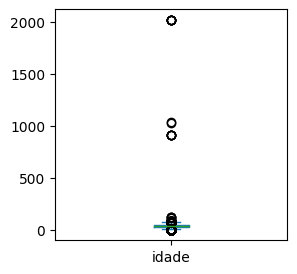

In [ ]:
print(condutores['idade'].describe())
condutores['idade'].plot.box(figsize=(3,3))

In [ ]:
condutores[(condutores['idade'] >= 90) | (condutores['idade'] <= 10)]

,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo,grupo_veiculo
1,317,340,Caminhão,VW/24.250 CLC 6X2/24.250 CLC 6X2/24.250 CLC 6X2,2007.0,Condutor,0.0,Masculino,caminhoes
17,2010,3066,Caminhão,FORD/CARGO 1418/CARGO 1418/CARGO 1418,1989.0,Condutor,0.0,Não Informado,caminhoes
24,2771,4467,Caminhão,FORD/F4000 G/F4000 G/F4000 G,2005.0,Condutor,0.0,Não Informado,caminhoes
26,2775,5374,Caminhão,FORD/F4000 G/F4000 G/F4000 G,2005.0,Condutor,0.0,Não Informado,caminhoes
28,2809,6431,Caminhão-trator,Não Informado/Não Informado/Não Informado/Não ...,0.0,Condutor,0.0,Não Informado,caminhoes
...,...,...,...,...,...,...,...,...,...
19783,240739,431620,Motocicleta,HONDA/CG 150 TITAN ESD,2015.0,Condutor,0.0,Masculino,motocicletas
24776,298907,534457,Motocicleta,HONDA/CG 125 FAN ES,2012.0,Condutor,909.0,Masculino,motocicletas
25227,305202,546375,Camioneta,GM/BLAZER,2000.0,Condutor,10.0,Feminino,automoveis
44682,545512,967473,Motocicleta,NaN,NaN,Condutor,1023.0,Masculino,motocicletas


In [ ]:
condutores['idade'] = condutores['idade'].apply(lambda x: np.nan if (x > 90) | (x<=10) else x)
condutores[condutores['idade'] < 15]

,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo,grupo_veiculo
4054,40103,69955,Ciclomotor,I/SHINERAY/SHINERAY/SHINERAY,0.0,Condutor,14.0,Masculino,motocicletas
7138,84340,149941,Motoneta,Não Informado/Não Informado/Não Informado/Não ...,0.0,Condutor,13.0,Masculino,motocicletas
24406,294240,525725,Motocicleta,NaN,NaN,Condutor,13.0,Masculino,motocicletas
25537,309130,553763,Motocicleta,SHINERAY/XY50Q-2,NaN,Condutor,14.0,Masculino,motocicletas
46373,564573,1004379,Motocicleta,HONDA/CG 150 TITAN KS,2008.0,Condutor,14.0,Masculino,motocicletas


In [ ]:
bins_idade = [0, 19, 29, 39, 49, 59, 69, 79, 89]
# bins_idade.append(int(condutores['idade'].max()) + 1)
# Criar rótulos para os bins
labels = [f'{bins_idade[i]}-{bins_idade[i+1]-1}' for i in range(len(bins_idade)-1)]
labels[-1] = str(bins_idade[-2]) + '+'

condutores['faixa_etaria'] = pd.cut(condutores['idade'], bins=bins_idade, labels=labels, right=False)

In [ ]:
condutores['idade'].isnull().sum()

4007

In [ ]:
condutores['faixa_etaria'] = condutores['faixa_etaria'].astype('category')
condutores['faixa_etaria'] = condutores['faixa_etaria'].cat.add_categories('idade_ignorada')
condutores['faixa_etaria'] = condutores['faixa_etaria'].fillna('idade_ignorada')
condutores['faixa_etaria'].isnull().sum()

0

In [ ]:
condutores.head()

,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo,grupo_veiculo,faixa_etaria
0,192,161,Caminhão,I/M.BENZ 415 MARIMAR AMB/M.BENZ 415 MARIMAR AM...,2013.0,Condutor,35.0,Masculino,caminhoes,29-38
1,317,340,Caminhão,VW/24.250 CLC 6X2/24.250 CLC 6X2/24.250 CLC 6X2,2007.0,Condutor,NaN,Masculino,caminhoes,idade_ignorada
2,319,366,Caminhão,M.BENZ/710/710/710,2000.0,Condutor,36.0,Masculino,caminhoes,29-38
3,369,529,Caminhão,FORD/F250 XL F22/F250 XL F22/F250 XL F22,2007.0,Condutor,37.0,Masculino,caminhoes,29-38
4,369,528,Caminhão,VW/8.150 E DELIVERY PLUS/8.150 E DELIVERY PLUS...,2011.0,Condutor,27.0,Masculino,caminhoes,19-28


In [ ]:
condutores['faixa_etaria'].cat.categories

Index(['0-18', '19-28', '29-38', '39-48', '49-58', '59-68', '69-78', '79+',
       'idade_ignorada'],
      dtype='object')

In [ ]:
faixas_etarias = condutores.groupby(['id','faixa_etaria']).size().unstack(fill_value=0)
faixas_etarias

faixa_etaria,0-18,19-28,29-38,39-48,49-58,59-68,69-78,79+,idade_ignorada
id,,,,,,,,,
19,0,0,0,1,0,0,0,0,1
88,0,0,1,0,0,0,0,0,1
141,0,0,1,0,0,0,0,0,0
157,0,0,0,0,0,0,0,0,1
192,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
576999,0,0,0,0,0,0,0,0,1
578174,0,0,0,0,0,0,0,0,3
578195,0,0,2,0,0,0,0,0,0


In [ ]:
faixas_etarias.dtypes

faixa_etaria
0-18              int64
19-28             int64
29-38             int64
39-48             int64
49-58             int64
59-68             int64
69-78             int64
79+               int64
idade_ignorada    int64
dtype: object

In [ ]:
ocorrencias = ocorrencias.merge(faixas_etarias, how='left', left_on='id', right_index=True)
ocorrencias.head()

,id,data_hora,ano,mes,dia,trimestre,hora,periodo_dia,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,veiculos_ignorados,0-18,19-28,29-38,39-48,49-58,59-68,69-78,79+,idade_ignorada
0,192,2017-01-01 15:55:00,2017,1,1,1,15.916667,Tarde,domingo,PE,101,62.8,RECIFE,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,0,1,1,1,1,2,-8.007427,-34.937846,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,2,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,317,2017-01-01 22:00:00,2017,1,1,1,22.000000,Noite,domingo,PE,232,142.0,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-8.326607,-36.115645,SPRF-PE,DEL02-PE,UOP03-DEL02-PE,0,0,0,1,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,319,2017-01-01 21:30:00,2017,1,1,1,21.500000,Noite,domingo,PE,232,84.7,GRAVATA,Animais na Pista,Atropelamento de Animal,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,1,0,0,0,1,0,0,1,-8.215031,-35.635721,SPRF-PE,DEL01-PE,UOP02-DEL02PE,0,0,0,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,369,2017-01-02 06:30:00,2017,1,2,1,6.500000,Manhã,segunda-feira,PE,101,23.0,GOIANA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-7.684500,-34.923700,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,0,0,0,2,0,0,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,483,2017-01-02 13:50:00,2017,1,2,1,13.833333,Tarde,segunda-feira,PE,101,73.2,RECIFE,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Pleno dia,Decrescente,Céu Claro,Dupla,Curva,Sim,3,0,0,0,3,0,0,2,-8.096529,-34.949602,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,0,0,1,1,0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
ocorrencias[ocorrencias.columns[-9:]].isnull().sum()

0-18              27
19-28             27
29-38             27
39-48             27
49-58             27
59-68             27
69-78             27
79+               27
idade_ignorada    27
dtype: int64

In [ ]:
ocorrencias[ocorrencias.columns[-9:]] = ocorrencias[ocorrencias.columns[-9:]].fillna(0)
ocorrencias[ocorrencias.columns[-9:]] = ocorrencias[ocorrencias.columns[-9:]].astype(int)

In [ ]:
ocorrencias[ocorrencias.columns[-9:]].isnull().sum()

0-18              0
19-28             0
29-38             0
39-48             0
49-58             0
59-68             0
69-78             0
79+               0
idade_ignorada    0
dtype: int64

###Tag Pedestre

In [ ]:
envolvidos.head()

,id,id_veiculo,tipo_veiculo,marca,ano_fabricacao_veiculo,tipo_envolvido,idade,sexo,grupo_veiculo
0,192,161,Caminhão,I/M.BENZ 415 MARIMAR AMB/M.BENZ 415 MARIMAR AM...,2013.0,Condutor,35.0,Masculino,caminhoes
1,317,340,Caminhão,VW/24.250 CLC 6X2/24.250 CLC 6X2/24.250 CLC 6X2,2007.0,Condutor,0.0,Masculino,caminhoes
2,319,366,Caminhão,M.BENZ/710/710/710,2000.0,Condutor,36.0,Masculino,caminhoes
3,369,529,Caminhão,FORD/F250 XL F22/F250 XL F22/F250 XL F22,2007.0,Condutor,37.0,Masculino,caminhoes
4,369,528,Caminhão,VW/8.150 E DELIVERY PLUS/8.150 E DELIVERY PLUS...,2011.0,Condutor,27.0,Masculino,caminhoes


In [ ]:
# Contar a quantidade de pedestres em cada acidente
contagem_pedestres = envolvidos[envolvidos['tipo_envolvido'] == 'Pedestre'].groupby('id').size()

# Renomear a série para 'pedestres'
contagem_pedestres = contagem_pedestres.rename('pedestres')

# Unir a contagem de pedestres ao DataFrame 'ocorrencias'
ocorrencias = ocorrencias.merge(contagem_pedestres, how='left', left_on='id', right_index=True)
ocorrencias['pedestres'].fillna(0, inplace=True)
ocorrencias['pedestres'] = ocorrencias['pedestres'].astype(int)

ocorrencias.head()

,id,data_hora,ano,mes,dia,trimestre,hora,periodo_dia,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,veiculos_ignorados,0-18,19-28,29-38,39-48,49-58,59-68,69-78,79+,idade_ignorada,pedestres
0,192,2017-01-01 15:55:00,2017,1,1,1,15.916667,Tarde,domingo,PE,101,62.8,RECIFE,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,0,1,1,1,1,2,-8.007427,-34.937846,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,317,2017-01-01 22:00:00,2017,1,1,1,22.000000,Noite,domingo,PE,232,142.0,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-8.326607,-36.115645,SPRF-PE,DEL02-PE,UOP03-DEL02-PE,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0
2,319,2017-01-01 21:30:00,2017,1,1,1,21.500000,Noite,domingo,PE,232,84.7,GRAVATA,Animais na Pista,Atropelamento de Animal,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,1,0,0,0,1,0,0,1,-8.215031,-35.635721,SPRF-PE,DEL01-PE,UOP02-DEL02PE,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,369,2017-01-02 06:30:00,2017,1,2,1,6.500000,Manhã,segunda-feira,PE,101,23.0,GOIANA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-7.684500,-34.923700,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,483,2017-01-02 13:50:00,2017,1,2,1,13.833333,Tarde,segunda-feira,PE,101,73.2,RECIFE,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Pleno dia,Decrescente,Céu Claro,Dupla,Curva,Sim,3,0,0,0,3,0,0,2,-8.096529,-34.949602,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [ ]:
ocorrencias['pedestres'].isnull().sum()

0

In [ ]:
# estatísticas básicas
ocorrencias.describe()

,id,data_hora,ano,mes,dia,trimestre,hora,km,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,veiculos_ignorados,0-18,19-28,29-38,39-48,49-58,59-68,69-78,79+,idade_ignorada,pedestres
count,19717.000000,19717,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.00000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000
mean,290804.296850,2020-06-08 13:27:00.027387136,2019.925699,6.645534,15.664300,2.541614,13.464614,106.857210,2.383324,0.109144,0.745702,0.303038,0.989552,0.243445,1.04874,1.767662,-8.273038,-36.279643,0.031191,0.000964,0.879799,0.266268,0.464269,0.026475,0.053761,0.035198,0.014455,0.008013,0.284222,0.459908,0.378810,0.209515,0.103413,0.029670,0.004412,0.203226,0.080387
min,19.000000,2017-01-01 00:30:00,2017.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,-19.311143,-47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,148354.000000,2018-07-18 07:20:00,2018.000000,4.000000,8.000000,2.000000,8.583333,50.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,-8.392345,-36.642771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,289392.000000,2020-06-01 17:20:00,2020.000000,7.000000,16.000000,3.000000,14.233333,77.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,2.000000,-8.141695,-35.422376,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,447590.000000,2022-04-27 19:00:00,2022.000000,10.000000,23.000000,4.000000,18.416667,126.500000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,2.000000,-8.019205,-34.946136,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,586766.000000,2023-12-31 21:50:00,2023.000000,12.000000,31.000000,4.000000,23.916667,559.400000,52.000000,7.000000,33.000000,12.000000,50.000000,15.000000,35.00000,14.000000,7.908900,40.016300,6.000000,1.000000,10.000000,5.000000,4.000000,3.000000,3.000000,4.000000,2.000000,2.000000,4.000000,5.000000,4.000000,4.000000,3.000000,2.000000,1.000000,5.000000,11.000000
std,167845.668725,NaN,2.074737,3.492679,8.727511,1.127343,5.949362,99.880508,1.570499,0.356313,1.012675,0.621533,1.239970,0.549048,1.13226,0.761290,0.446413,1.894344,0.206878,0.031028,0.791423,0.508005,0.565370,0.166745,0.231323,0.228295,0.121464,0.089727,0.491417,0.614607,0.569463,0.439797,0.314824,0.171759,0.066281,0.437205,0.306948


##### pessoa_veiculo (Tukey)

count    19717.000000
mean         1.417822
std          0.990140
min          0.500000
25%          1.000000
50%          1.000000
75%          1.500000
max         45.000000
Name: pessoas_veiculo, dtype: float64


<Axes: >

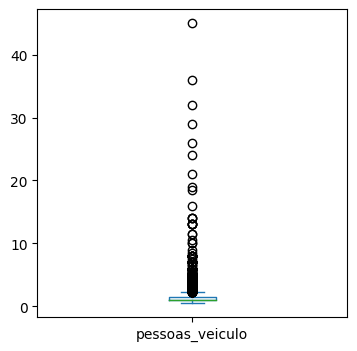

In [ ]:
# Verificar relação pessoas x veículos
ocorrencias['pessoas_veiculo'] = ocorrencias['pessoas'] / ocorrencias['veiculos']
print(ocorrencias['pessoas_veiculo'].describe())
ocorrencias['pessoas_veiculo'].plot.box(figsize=(4,4))

Vemos que o corpo do boxplot está achatado, indicando alta concentração dos dados com baixos valores, com um denso rastro de pontos logo acima do whisker superior.

Nesse caso, ao aplicarmos o **método Tukey** vamos precisar reajustar esse limiar, para não tratar essa área densa de pontos como outliers.

<Axes: xlabel='veiculos', ylabel='pessoas'>

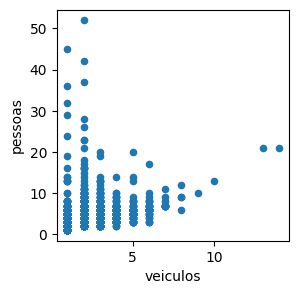

In [ ]:
# dispersão
ocorrencias.plot.scatter(x='veiculos',y='pessoas', figsize=(3,3))

In [ ]:
# Verificação dos quartis e IQR
q1 = ocorrencias['pessoas_veiculo'].quantile(q=0.25)
q3 = ocorrencias['pessoas_veiculo'].quantile(q=0.75)
iqr = q3 - q1
print(f"IQR: {iqr}")
print(f"Q1: {q1}")
print(f"Q3: {q3}")

IQR: 0.5
Q1: 1.0
Q3: 1.5


Ao verificaros os quartis e o IQR, temos valores muito baixos (`iqr==0.5`).

Desse modo, vamos aplicar o método de **Tukey**, mas para adequá-lo à realidade de dispersão do atributo e aos baixos valores do IQR e quartis, vamos aumentar os limiares para detecção dos outliers.

Em vez da constante padrão de 1,5 utilizada na fórmula, vamos modificá-la para 27.

In [ ]:
# Outliers
outliers_tukey = ocorrencias[(ocorrencias['pessoas_veiculo'] > (q1-10*iqr)) & (ocorrencias['pessoas_veiculo'] > (q3+10*iqr))]
print(len(outliers_tukey))
outliers_tukey

49


,id,data_hora,ano,mes,dia,trimestre,hora,periodo_dia,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,veiculos_ignorados,0-18,19-28,29-38,39-48,49-58,59-68,69-78,79+,idade_ignorada,pedestres,pessoas_veiculo
1036,7963,2017-01-30 16:05:00,2017,1,30,1,16.083333,Tarde,segunda-feira,PE,424,85.7,GARANHUNS,Velocidade Incompatível,Saída de leito carroçável,Com Vítimas Fatais,Pleno dia,Decrescente,Chuva,Simples,Reta,Sim,19,1,15,3,0,0,18,1,-8.864869,-36.509314,SPRF-PE,DEL03-PE,UOP01-DEL03-PE,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,19.000000
1313,19085,2017-03-12 08:30:00,2017,3,12,1,8.500000,Manhã,domingo,PE,408,92.1,SAO LOURENCO DA MATA,Defeito na Via,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Crescente,Chuva,Dupla,Reta,Não,8,0,2,2,4,0,4,1,-8.000462,-35.061516,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,8.000000
1755,36159,2017-05-11 04:00:00,2017,5,11,2,4.000000,Madrugada,quinta-feira,PE,428,100.0,SANTA MARIA DA BOA VISTA,Falta de Atenção à Condução,Atropelamento de Animal,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,7,0,0,0,7,0,0,1,-8.801618,-39.895821,SPRF-PE,DEL06-PE,UOP03-DEL06-PE,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7.000000
2060,46182,2017-04-27 11:20:00,2017,4,27,2,11.333333,Manhã,quinta-feira,PE,232,109.9,BEZERROS,Mal Súbito,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Crescente,Sol,Dupla,Retorno Regulamentado,Não,24,0,1,0,23,0,1,1,-8.287976,-35.819217,SPRF-PE,DEL02-PE,UOP03-DEL02-PE,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,24.000000
2395,58696,2017-07-31 17:50:00,2017,7,31,3,17.833333,Tarde,segunda-feira,PE,232,223.1,PESQUEIRA,Falta de Atenção à Condução,Capotamento,Com Vítimas Feridas,Anoitecer,Crescente,Garoa/Chuvisco,Simples,Reta,Não,36,0,33,2,0,1,35,1,-8.402780,-36.801460,SPRF-PE,DEL03-PE,UOP02-DEL03-PE,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,36.000000
3185,91473,2017-07-10 03:40:00,2017,7,10,3,3.666667,Madrugada,segunda-feira,PE,408,98.0,SAO LOURENCO DA MATA,Animais na Pista,Atropelamento de Animal,Com Vítimas Feridas,Plena Noite,Decrescente,Nublado,Dupla,Reta,Não,8,0,5,3,0,0,8,1,-8.041192,-35.024052,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,8.000000
3438,240912,2017-04-26 18:10:00,2017,4,26,2,18.166667,Noite,quarta-feira,PE,110,256.0,JATOBA,Animais na Pista,Colisão frontal,Com Vítimas Fatais,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,14,1,12,1,0,0,13,2,-9.253400,-38.239000,SPRF-BA,DEL07-BA,UOP01-DEL07-BA,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,7.000000
3530,111839,2018-02-17 07:40:00,2018,2,17,1,7.666667,Manhã,sábado,PE,424,47.7,VENTUROSA,Defeito Mecânico no Veículo,Capotamento,Com Vítimas Fatais,Pleno dia,Decrescente,Nublado,Simples,Curva;Declive,Não,7,2,1,4,0,0,5,1,-8.702029,-36.790309,SPRF-PE,DEL03-PE,UOP01-DEL03-PE,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7.000000
3735,139683,2018-06-12 08:30:00,2018,6,12,2,8.500000,Manhã,terça-feira,PE,424,55.4,CAETES,Falta de Atenção à Condução,Colisão lateral,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Reta,Não,16,0,5,0,11,0,5,2,-8.731866,-36.745438,SPRF-PE,DEL03-PE,UOP01-DEL03-PE,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,8.000000
3949,166337,2018-09-25 06:15:00,2018,9,25,3,6.250000,Manhã,terça-feira,PE,428,164.8,PETROLINA,Avarias e/ou desgaste excessivo no pneu,Colisão frontal,Com Vítimas Fatais,Pleno dia,Decrescente,Céu Claro,Simples,Reta,Não,20,4,12,2,2,0,14,3,-9.191454,-40.383979,SPRF-PE,DEL06-PE,UOP01-DEL06-PE,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,6.666667


Os candidatos a outliers são ocorrências com altas médias de pessoas/veículo (entre 17 e 51).

Novamente são possivelmente acidentes envolvendo ônibus, que comportam diversos passageiros.

### Informações de radares

Criadas 3 novas colunas em `'ocorrencias'` para indicar a quantidade radares nas proximidades do acidente:

- `'radar_500m'`: até 500m de distância
- `'radar_1km'`: até 1km de distância
- `'radar_5km'`: até 5km de distância

As informações serão úteis para analisar se acidentes em proximidades de radares apresentam condições distintas dos demais.

In [ ]:
# Criar coluna 'radar_500m': quantidade de radares em um raio de 500m do acidente
#ocorrencias['radar_500m'] = ocorrencias.apply(lambda linha: count_radares(linha['uf'], linha['br'], linha['km'], 0.5), axis=1)

In [ ]:
# Criar coluna 'radar_1km': quantidade de radares em um raio de 1km do acidente
ocorrencias['radar_1km'] = ocorrencias.apply(lambda linha: count_radares(linha['uf'], linha['br'], linha['km'], 1), axis=1)

In [ ]:
# Criar coluna 'radar_5km': quantidade de radares em um raio de 5km do acidente
#ocorrencias['radar_5km'] = ocorrencias.apply(lambda linha: count_radares(linha['uf'], linha['br'], linha['km'], 5), axis=1)

In [ ]:
ocorrencias.head()

,id,data_hora,ano,mes,dia,trimestre,hora,periodo_dia,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,veiculos_ignorados,0-18,19-28,29-38,39-48,49-58,59-68,69-78,79+,idade_ignorada,pedestres,pessoas_veiculo,radar_1km
0,192,2017-01-01 15:55:00,2017,1,1,1,15.916667,Tarde,domingo,PE,101,62.8,RECIFE,Falta de Atenção do Pedestre,Atropelamento de Pedestre,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Dupla,Reta,Sim,3,0,0,1,1,1,1,2,-8.007427,-34.937846,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1.5,1
1,317,2017-01-01 22:00:00,2017,1,1,1,22.000000,Noite,domingo,PE,232,142.0,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-8.326607,-36.115645,SPRF-PE,DEL02-PE,UOP03-DEL02-PE,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1.0,0
2,319,2017-01-01 21:30:00,2017,1,1,1,21.500000,Noite,domingo,PE,232,84.7,GRAVATA,Animais na Pista,Atropelamento de Animal,Sem Vítimas,Plena Noite,Decrescente,Céu Claro,Simples,Reta,Não,1,0,0,0,1,0,0,1,-8.215031,-35.635721,SPRF-PE,DEL01-PE,UOP02-DEL02PE,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.0,0
3,369,2017-01-02 06:30:00,2017,1,2,1,6.500000,Manhã,segunda-feira,PE,101,23.0,GOIANA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-7.684500,-34.923700,SPRF-PE,DEL01-PE,UOP02-DEL01-PE,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1.0,0
4,483,2017-01-02 13:50:00,2017,1,2,1,13.833333,Tarde,segunda-feira,PE,101,73.2,RECIFE,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Pleno dia,Decrescente,Céu Claro,Dupla,Curva,Sim,3,0,0,0,3,0,0,2,-8.096529,-34.949602,SPRF-PE,DEL01-PE,UOP01-DEL01-PE,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1.5,3


In [ ]:
# estatísticas básicas das novas colunas
ocorrencias.describe()[['radar_1km']]
#ocorrencias.describe()[['radar_500m', 'radar_1km', 'radar_5km']]

,radar_1km
count,19717.000000
mean,0.423188
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,4.000000
std,0.783623


In [ ]:
# Salvar CSV
#ocorrencias.to_csv(pathBkp + 'acidentes2019-2023_pe.csv', index=False, encoding='latin1')

In [ ]:
# Salvar CSV
#ocorrencias.to_csv(pathBkp + 'acidentes2017-2023_pe.csv', index=False, encoding='latin1')

###### *Checkpoint*


In [ ]:
# PARA AGILIZAR TESTES - abrir csvs
'''ocorrencias_code = pd.read_csv(path + 'ocorrencias_code.csv')
ocorrencias = pd.read_csv(path + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})
ocorrencias[categoricos] = ocorrencias[categoricos].astype('category')
ocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])
print(ocorrencias.dtypes)
print(ocorrencias_code.dtypes)'''


"ocorrencias_code = pd.read_csv(path + 'ocorrencias_code.csv')\nocorrencias = pd.read_csv(path + 'acidentes2023_ne.csv', encoding='latin1', dtype={'br': 'str'})\nocorrencias[categoricos] = ocorrencias[categoricos].astype('category')\nocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])\nprint(ocorrencias.dtypes)\nprint(ocorrencias_code.dtypes)"

### causas acidentes

In [ ]:
ocorrencias['causa_acidente'].cat.categories

Index(['Acessar a via sem observar a presença dos outros veículos',
       'Acesso irregular', 'Acostamento em desnível',
       'Acumulo de areia ou detritos sobre o pavimento',
       'Acumulo de água sobre o pavimento',
       'Acumulo de óleo sobre o pavimento',
       'Afundamento ou ondulação no pavimento', 'Agressão Externa',
       'Animais na Pista', 'Ausência de reação do condutor',
       'Ausência de sinalização', 'Avarias e/ou desgaste excessivo no pneu',
       'Carga excessiva e/ou mal acondicionada', 'Chuva', 'Condutor Dormindo',
       'Condutor deixou de manter distância do veículo da frente',
       'Condutor desrespeitou a iluminação vermelha do semáforo',
       'Condutor usando celular', 'Conversão proibida', 'Curva acentuada',
       'Declive acentuado', 'Defeito Mecânico no Veículo', 'Defeito na Via',
       'Deficiência do Sistema de Iluminação/Sinalização',
       'Deficiência ou não Acionamento do Sistema de Iluminação/Sinalização do Veículo',
       'Deixar 

In [ ]:
classes_acidentes = pd.read_csv(pathUtil + "classes_causas_acidentes.csv", sep=';', dtype='category')
classes_acidentes

,causa_acidente,classes_4,classes_8,classes_4_bal,classes_2,classes_condutor
0,Acessar a via sem observar a presença dos outr...,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
1,Acesso irregular,Estrutura Viária,Estrutura Viária,Fatores Externos,Fator Externo,Outros
2,Acostamento em desnível,Estrutura Viária,Estrutura Viária,Fatores Externos,Fator Externo,Outros
3,Acumulo de areia ou detritos sobre o pavimento,Estrutura Viária,Estrutura Viária,Fatores Externos,Fator Externo,Outros
4,Acumulo de água sobre o pavimento,Estrutura Viária,Estrutura Viária,Fatores Externos,Fator Externo,Outros
...,...,...,...,...,...,...
81,Transitar no acostamento,Fator Humano,Imprudência,Imprudência ou Desrespeito a Normas,Fator Humano,Condutor
82,Transtornos Mentais (exceto suicidio),Fator Humano,Enfermidade ou Agressão,Psicoativos/Enfermidade ou Agressão,Fator Humano,Outros
83,Ultrapassagem Indevida,Fator Humano,Imprudência,Imprudência ou Desrespeito a Normas,Fator Humano,Condutor
84,Velocidade Incompatível,Fator Humano,Imprudência,Imprudência ou Desrespeito a Normas,Fator Humano,Condutor


In [ ]:
ocorrencias = ocorrencias.merge(classes_acidentes, how='left', on='causa_acidente')
ocorrencias[ocorrencias.classes_4.isnull()]['causa_acidente']

Series([], Name: causa_acidente, dtype: object)

In [ ]:
ocorrencias.columns

Index(['id', 'data_hora', 'ano', 'mes', 'dia', 'trimestre', 'hora',
       'periodo_dia', 'dia_semana', 'uf', 'br', 'km', 'municipio',
       'causa_acidente', 'tipo_acidente', 'classificacao_acidente', 'fase_dia',
       'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via',
       'uso_solo', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves',
       'ilesos', 'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude',
       'regional', 'delegacia', 'uop', 'Outros', 'agricolas', 'automoveis',
       'caminhoes', 'motocicletas', 'nao_motorizados', 'onibus', 'reboques',
       'veiculos_ignorados', '0-18', '19-28', '29-38', '39-48', '49-58',
       '59-68', '69-78', '79+', 'idade_ignorada', 'pedestres',
       'pessoas_veiculo', 'radar_1km', 'classes_4', 'classes_8',
       'classes_4_bal', 'classes_2', 'classes_condutor'],
      dtype='object')

In [ ]:
print(ocorrencias['classificacao_acidente'].value_counts(), '\n')
print(ocorrencias['classes_4'].value_counts(), '\n')
print(ocorrencias['classes_4_bal'].value_counts(), '\n')
print(ocorrencias['classes_8'].value_counts(), '\n')
print(ocorrencias['classes_2'].value_counts(), '\n')
print(ocorrencias['classes_condutor'].value_counts())

classificacao_acidente
Com Vítimas Feridas    13270
Sem Vítimas             4520
Com Vítimas Fatais      1927
Name: count, dtype: int64 

classes_4
Fator Humano            15857
Estrutura Viária         1509
Condições Veiculares     1332
Fatores Naturais         1019
Name: count, dtype: int64 

classes_4_bal
Atenção ou Reação Ineficientes         8573
Imprudência ou Desrespeito a Normas    5409
Fatores Externos                       3860
Psicoativos/Enfermidade ou Agressão    1875
Name: count, dtype: int64 

classes_8
Atenção ou Reação Ineficientes    8573
Desrespeito a normas              2832
Imprudência                       2577
Uso de Psicoativos                1623
Estrutura Viária                  1509
Condições Veiculares              1332
Fatores Naturais                  1019
Enfermidade ou Agressão            252
Name: count, dtype: int64 

classes_2
Fator Humano     15857
Fator Externo     3860
Name: count, dtype: int64 

classes_condutor
Condutor    14533
Outros       5184

### Duplicatas e dados irrelevantes (Outliers)

Consideramos duplicatas ocorrências que tenham o mesmo 'id' no banco de dados, ou que apresentem identidade de alguns atributos chave, indicando se tratarem de registros realizados em duplicidade: `'data_hora', 'uf', 'br', 'km', 'causa_acidente', 'tipo_acidente', 'pessoas', 'veiculos'`

In [ ]:
# IDs únicos (verificar se há registros duplicados no banco de dados)
print(f"IDs únicos? {ocorrencias['id'].nunique() == len(ocorrencias['id'])}")

IDs únicos? True


In [ ]:
# Verificar acidentes possivelmente registrados em duplicidade
ocorrencias[ocorrencias.duplicated(subset=['data_hora', 'uf', 'br', 'km', 'veiculos', 'pessoas'], keep=False)]

,id,data_hora,ano,mes,dia,trimestre,hora,periodo_dia,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,veiculos_ignorados,0-18,19-28,29-38,39-48,49-58,59-68,69-78,79+,idade_ignorada,pedestres,pessoas_veiculo,radar_1km,classes_4,classes_8,classes_4_bal,classes_2,classes_condutor
1,317,2017-01-01 22:00:00,2017,1,1,1,22.000000,Noite,domingo,PE,232,142.0,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-8.326607,-36.115645,SPRF-PE,DEL02-PE,UOP03-DEL02-PE,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1.0,0,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
17,2389,2017-01-01 22:00:00,2017,1,1,1,22.000000,Noite,domingo,PE,232,142.0,SAO CAITANO,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Plena Noite,Crescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-8.323635,-36.105752,SPRF-PE,DEL02-PE,UOP03-DEL02-PE,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,1.0,0,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
40,5967,2017-01-22 11:05:00,2017,1,22,1,11.083333,Manhã,domingo,PE,232,87.0,GRAVATA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Sol,Dupla,Declive,Não,2,0,0,0,2,0,0,2,-8.214300,-35.630900,SPRF-PE,DEL01-PE,UOP02-DEL02PE,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1.0,0,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
984,5828,2017-01-22 11:05:00,2017,1,22,1,11.083333,Manhã,domingo,PE,232,87.0,GRAVATA,Falta de Atenção à Condução,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Céu Claro,Dupla,Reta,Não,2,0,0,0,2,0,0,2,-8.214300,-35.630900,SPRF-PE,DEL01-PE,UOP02-DEL02PE,0,0,2,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1.0,0,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
1235,16206,2017-03-01 13:40:00,2017,3,1,1,13.666667,Tarde,quarta-feira,PE,101,205.0,XEXEU,Falta de Atenção à Condução,Colisão traseira,Com Vítimas Feridas,Pleno dia,Decrescente,Chuva,Simples,Curva,Sim,2,0,1,0,1,0,1,2,-8.805200,-35.627300,SPRF-PE,DEL01-PE,UOP03-DEL01-PE,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1.0,0,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
1237,16228,2017-03-01 13:40:00,2017,3,1,1,13.666667,Tarde,quarta-feira,PE,101,205.0,XEXEU,Não guardar distância de segurança,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Chuva,Simples,Curva,Sim,2,0,0,0,2,0,0,2,-8.805200,-35.627300,SPRF-PE,DEL01-PE,UOP03-DEL01-PE,0,0,2,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1.0,0,Fator Humano,Desrespeito a normas,Imprudência ou Desrespeito a Normas,Fator Humano,Condutor
4194,103035,2018-01-12 19:15:00,2018,1,12,1,19.250000,Noite,sexta-feira,PE,232,28.0,MORENO,Restrição de Visibilidade,Colisão com objeto em movimento,Com Vítimas Feridas,Plena Noite,Decrescente,Ignorado,Dupla,Reta,Não,1,0,1,0,0,0,1,1,-8.112907,-35.134430,SPRF-PE,DEL01-PE,UOP02-DEL02PE,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,0,Estrutura Viária,Estrutura Viária,Fatores Externos,Fator Externo,Outros
4195,103036,2018-01-12 19:15:00,2018,1,12,1,19.250000,Noite,sexta-feira,PE,232,28.0,MORENO,Objeto estático sobre o leito carroçável,Danos eventuais,Sem Vítimas,Pleno dia,Decrescente,Ignorado,Dupla,Reta,Não,1,0,0,0,1,0,0,1,-8.112907,-35.134430,SPRF-PE,DEL01-PE,UOP02-DEL02PE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,0,Estrutura Viária,Estrutura Viária,Fatores Externos,Fator Externo,Outros
8267,238953,2019-09-29 16:00:00,2019,9,29,3,16.000000,Tarde,domingo,PE,408,96.3,SAO LOURENCO DA MATA,Avarias e/ou desgaste excessivo no pneu,Capotamento,Com Vítimas Feridas,Pleno dia,Decrescente,Céu Claro,Dupla,

In [ ]:
# Excluir dados irrelevantes (colunas não utilizadas nas análises)
ocorrencias.drop(['id', 'uf', 'periodo_dia', 'tracado_via', 'latitude', 'longitude', 'regional', 'delegacia', 'uop', 'pessoas_veiculo', 'causa_acidente'], axis=1, inplace=True)

In [ ]:
ocorrencias.columns

Index(['data_hora', 'ano', 'mes', 'dia', 'trimestre', 'hora', 'dia_semana',
       'br', 'km', 'municipio', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'uso_solo', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves',
       'ilesos', 'ignorados', 'feridos', 'veiculos', 'Outros', 'agricolas',
       'automoveis', 'caminhoes', 'motocicletas', 'nao_motorizados', 'onibus',
       'reboques', 'veiculos_ignorados', '0-18', '19-28', '29-38', '39-48',
       '49-58', '59-68', '69-78', '79+', 'idade_ignorada', 'pedestres',
       'radar_1km', 'classes_4', 'classes_8', 'classes_4_bal', 'classes_2',
       'classes_condutor'],
      dtype='object')

In [ ]:
ocorrencias.dtypes

data_hora                 datetime64[ns]
ano                                int64
mes                                int64
dia                                int64
trimestre                          int64
hora                             float64
dia_semana                      category
br                              category
km                               float64
municipio                       category
tipo_acidente                   category
classificacao_acidente          category
fase_dia                        category
sentido_via                     category
condicao_metereologica          category
tipo_pista                      category
uso_solo                        category
pessoas                            int64
mortos                             int64
feridos_leves                      int64
feridos_graves                     int64
ilesos                             int64
ignorados                          int64
feridos                            int64
veiculos        

### Encoding

In [ ]:
# Converter tipos categóricos para códigos
ocorrencias_code = ocorrencias.copy()
categoricos = ['dia_semana', 'br', 'municipio', 'tipo_acidente', 'classificacao_acidente', 'fase_dia',
               'sentido_via', 'condicao_metereologica', 'tipo_pista', 'uso_solo', 'classes_4', 'classes_8', 'classes_4_bal', 'classes_2', 'classes_condutor']

for coluna in categoricos:
  ocorrencias_code[coluna] = ocorrencias_code[coluna].cat.codes

# data_hora para int
ocorrencias_code['data_hora'] = ocorrencias_code['data_hora'].astype('int64')/ 10**9  # De nanosegundo para segundo

In [ ]:
ocorrencias_code.head()

,data_hora,ano,mes,dia,trimestre,hora,dia_semana,br,km,municipio,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,Outros,agricolas,automoveis,caminhoes,motocicletas,nao_motorizados,onibus,reboques,veiculos_ignorados,0-18,19-28,29-38,39-48,49-58,59-68,69-78,79+,idade_ignorada,pedestres,radar_1km,classes_4,classes_8,classes_4_bal,classes_2,classes_condutor
0,1.483286e+09,2017,1,1,1,15.916667,1,0,62.8,68,1,1,1,1,1,1,1,3,0,0,1,1,1,1,2,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,2,0,0,1,1
1,1.483308e+09,2017,1,1,1,22.000000,1,5,142.0,75,7,0,3,1,1,1,0,2,0,0,0,2,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,1,0
2,1.483306e+09,2017,1,1,1,21.500000,1,5,84.7,34,0,0,3,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,5,1,0,1
3,1.483339e+09,2017,1,2,1,6.500000,2,0,23.0,33,11,0,1,0,2,1,0,2,0,0,0,2,0,0,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,1,0
4,1.483365e+09,2017,1,2,1,13.833333,2,0,73.2,68,7,0,1,0,1,1,1,3,0,0,0,3,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,3,2,0,0,1,0


# CHECKPOINT

Recarregar dados pré-processados para realizar treinamentos abaixo.

In [ ]:
# Salvar CSV
#ocorrencias.to_csv(pathBkp + 'ocorrencias.csv', index=False, encoding='latin1')
#ocorrencias_code.to_csv(pathBkp + 'ocorrencias_code.csv', index=False)


In [ ]:
# Salvar CSV
#ocorrencias.to_csv(pathBkp + 'ocorrencias_amp.csv', index=False, encoding='latin1')
#ocorrencias_code.to_csv(pathBkp + 'ocorrencias_code_amp.csv', index=False)

In [ ]:
# PARA AGILIZAR TESTES - abrir datasets pré-processados
def reload_checkpoint(amp=False):
  if amp:
    arqs = ['ocorrencias_code_amp.csv', 'ocorrencias_amp.csv']
  else:
    arqs = ['ocorrencias_code.csv', 'ocorrencias.csv']
  ocorrencias_code = pd.read_csv(pathBkp + arqs[0])
  ocorrencias = pd.read_csv(pathBkp + arqs[1], encoding='latin1', dtype={'br': 'str'})

  # Categóricos com ordem específica
  categorias_ordenadas = ['dia_semana', 'classificacao_acidente', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'uso_solo']

  # Lista das categorias específicas para cada coluna categórica
  lista_categorias = [
      ['zero', 'domingo', 'segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado'],
      ['Sem Vítimas', 'Com Vítimas Feridas', 'Com Vítimas Fatais'],
      ['Amanhecer', 'Pleno dia', 'Anoitecer', 'Plena Noite'],
      ['Decrescente', 'Crescente'],
      ['Ignorado', 'Céu Claro', 'Sol', 'Vento', 'Nublado', 'Garoa/Chuvisco', 'Chuva', 'Nevoeiro/Neblina', 'Neve'],
      ['Simples', 'Dupla', 'Múltipla'],
      ['Não', 'Sim']
  ]

  # Converter cada coluna categórica para o tipo categórico com ordem específica
  for coluna, categoria in zip(categorias_ordenadas, lista_categorias):
      dtype = CategoricalDtype(categories=categoria, ordered=True)
      ocorrencias[coluna] = ocorrencias[coluna].astype(dtype)

  # Categóricos (restante)
  categoricos_ocorrencias = ['br', 'municipio', 'tipo_acidente', 'classes_4', 'classes_8', 'classes_4_bal', 'classes_2', 'classes_condutor']
  ocorrencias[categoricos_ocorrencias] = ocorrencias[categoricos_ocorrencias].astype('category')

  # Data_hora
  ocorrencias['data_hora'] = pd.to_datetime(ocorrencias['data_hora'])

  return ocorrencias_code, ocorrencias

# CLASSIFICAÇÃO_ACIDENTE (target)

```
classificacao_acidente
0  Sem Vítimas            2621
1  Com Vítimas Feridas    9597
2  Com Vítimas Fatais     1351
```



Escolhemos como **target** o atributo **`'classificacao_acidente'`**.

Inicialmente treinamos modelos **Random Forest** com 3 abordagens:
1. Usando crossvalidation (sem balanceamento de dados)
2. Com conjuntos de treinamento e validação SEM balanceamento de dados
3. Com conjuntos de treinamento e validação COM balanceamento de dados

Os resultados da terceira estratégia foram mais equilibrados.
Com isso, a utilizamos para treinar mais 3 modelos: **XGBoost**, **SVM** e **KNN**.

Para o KNN, fizemos experimentos codificando os dados com encoding simples e com OneHotEncoding.


---


**Os melhores resultados foram do Random Forest**

Para tentar melhorá-los, ampliamos o dataset (acrescentando os dados de mais dois anos de ocorrências: 2017 e 2018) e realizamos novos treinamentos do modelo, obtendo discreta melhora.

## Seleção de features e target

In [ ]:
ocorrencias_code, ocorrencias = reload_checkpoint()
ocorrencias.columns

Index(['data_hora', 'ano', 'mes', 'dia', 'trimestre', 'hora', 'dia_semana',
       'br', 'km', 'municipio', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'uso_solo', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves',
       'ilesos', 'ignorados', 'feridos', 'veiculos', 'agricolas', 'automoveis',
       'caminhoes', 'motocicletas', 'nao_motorizados', 'onibus', 'reboques',
       'veiculos_ignorados', '0-18', '19-28', '29-38', '39-48', '49-58',
       '59-68', '69-78', '79+', 'idade_ignorada', 'pedestres', 'radar_1km',
       'classes_4', 'classes_8', 'classes_4_bal', 'classes_2',
       'classes_condutor'],
      dtype='object')

In [ ]:
# Eliminar features redundantes e targets não utilizados
# manter 'classes_8' como feature substituta de 'causa_acidente'
cols = ['ano', 'mes', 'dia', 'trimestre', 'hora', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos',
        'classes_4', 'classes_4_bal', 'classes_2', 'classes_condutor']
ocorrencias = ocorrencias.drop(cols, axis=1)
ocorrencias_code = ocorrencias_code.drop(cols, axis=1)

In [ ]:
ocorrencias.columns

Index(['data_hora', 'dia_semana', 'br', 'km', 'municipio', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'uso_solo', 'agricolas',
       'automoveis', 'caminhoes', 'motocicletas', 'nao_motorizados', 'onibus',
       'reboques', 'veiculos_ignorados', '0-18', '19-28', '29-38', '39-48',
       '49-58', '59-68', '69-78', '79+', 'idade_ignorada', 'pedestres',
       'radar_1km', 'classes_8'],
      dtype='object')

## Split (2023 .. Demais anos)

*   Teste:       2023
*   Treinamento: Demais anos



In [ ]:
# Datetime para inicio de 2023
start_2023 = datetime.datetime(year=2023, month=1, day=1, hour=0, minute=0, second=0)
start_2023_seconds = int(start_2023.timestamp())

# proporção de ocorrencias 2023
len_test = len(ocorrencias_code[ocorrencias_code.data_hora >= start_2023_seconds])
len_train = len(ocorrencias_code[ocorrencias_code.data_hora < start_2023_seconds])
print(len_test / (len_train + len_test))

0.22065001105460977


In [ ]:
# Separar X e y (Treino e teste) => Teste (ano de 2023) e Treino (Demais anos)
X = ocorrencias_code.drop(['classificacao_acidente'], axis=1)
X_train = X[X.data_hora >= start_2023_seconds]
X_test = X[X.data_hora < start_2023_seconds]

y_train = ocorrencias_code[ocorrencias_code.data_hora >= start_2023_seconds]['classificacao_acidente']
y_test = ocorrencias_code[ocorrencias_code.data_hora < start_2023_seconds]['classificacao_acidente']

### RandomForest_unbalanced_crosval - 04

In [ ]:
# Iniciar um experimento
exp_name = 'RandomForest_unbalanced_crossval_05'
mlflow.set_experiment(exp_name)

<Experiment: artifact_location='file:///content/drive/MyDrive/TCC/data/mlruns/769079871485840256', creation_time=1718983029084, experiment_id='769079871485840256', last_update_time=1718983029084, lifecycle_stage='active', name='RandomForest_unbalanced_crossval_05', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
      n_estimators = trial.suggest_int('n_estimators', 50, 300)
      max_depth = trial.suggest_int('max_depth', 10, 50)
      min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)

      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = RandomForestClassifier(
              criterion=criterion,
              n_estimators=n_estimators,
              max_depth=max_depth,
              min_samples_split=min_samples_split,
              min_samples_leaf=min_samples_leaf,
              random_state=SEED)

      # Usar a validação cruzada estratificada com múltiplas métricas
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
      metrics = {'accuracy': make_scorer(accuracy_score),
                  'precision': make_scorer(precision_score, average='macro'),
                  'recall': make_scorer(recall_score, average='macro'),
                  'f1_score': make_scorer(f1_score, average='macro')}
      results = cross_validate(model, X_train, y_train, cv=skf, scoring=metrics)

      # Treinar o modelo no conjunto completo para salvá-lo ajustado
      model.fit(X_train, y_train)

      # Calcular a média das métricas
      mean_accuracy = results['test_accuracy'].mean()
      mean_precision = results['test_precision'].mean()
      mean_recall = results['test_recall'].mean()
      mean_f1 = results['test_f1_score'].mean()

      # Logar parâmetros e métricas no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metrics({
          'mean_accuracy': mean_accuracy,
          'mean_precision': mean_precision,
          'mean_recall': mean_recall,
          'mean_f1': mean_f1
      })
      mlflow.sklearn.log_model(model, "model")

      return mean_accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-06-21 15:17:17,805] A new study created in memory with name: no-name-bd197110-6d44-4aa2-b6a9-b9934936bd66
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Melhores parâmetros: {'criterion': 'log_loss', 'n_estimators': 64, 'max_depth': 44, 'min_samples_split': 5, 'min_samples_leaf': 2}
Melhor acurácia: 0.7855740615630287


In [ ]:
ngrok.kill() # kill open tunnels
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLFlow Tracking UI:", ngrok_tunnel.public_url)

!mlflow ui

MLFlow Tracking UI: https://9617-34-83-74-218.ngrok-free.app
[2024-06-25 14:01:59 +0000] [7820] [INFO] Starting gunicorn 22.0.0
[2024-06-25 14:01:59 +0000] [7820] [INFO] Listening at: http://127.0.0.1:5000 (7820)
[2024-06-25 14:01:59 +0000] [7820] [INFO] Using worker: sync
[2024-06-25 14:01:59 +0000] [7821] [INFO] Booting worker with pid: 7821
[2024-06-25 14:01:59 +0000] [7822] [INFO] Booting worker with pid: 7822
[2024-06-25 14:01:59 +0000] [7823] [INFO] Booting worker with pid: 7823
[2024-06-25 14:01:59 +0000] [7824] [INFO] Booting worker with pid: 7824

[2024-06-25 14:02:02 +0000] [7820] [INFO] Handling signal: int
Aborted!
[2024-06-25 14:02:02 +0000] [7821] [INFO] Worker exiting (pid: 7821)
[2024-06-25 14:02:02 +0000] [7822] [INFO] Worker exiting (pid: 7822)
[2024-06-25 14:02:02 +0000] [7823] [INFO] Worker exiting (pid: 7823)
[2024-06-25 14:02:03 +0000] [7820] [INFO] Shutting down: Master


In [ ]:
# Acessar o experimento pelo nome
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)
best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: be474000a1974685a69c8384c0e2c367
Melhores Parâmetros:
criterion: log_loss
n_estimators: 81
max_depth: 37
min_samples_split: 6
min_samples_leaf: 3

Melhores Métricas:
mean_accuracy: 0.7785595836985835
mean_precision: 0.7370765901624939
mean_recall: 0.4101634299654712
mean_f1: 0.42466761088262645


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.19      0.30      2130
           1       0.72      0.98      0.83      7339
           2       0.80      0.04      0.08      1106

    accuracy                           0.72     10575
   macro avg       0.75      0.40      0.40     10575
weighted avg       0.73      0.72      0.65     10575

Confusion Matrix:
[[ 405 1725    0]
 [ 142 7185   12]
 [   6 1052   48]]
Accuracy by class:
Class 0: 19.01%
Class 1: 97.90%
Class 2: 4.34%


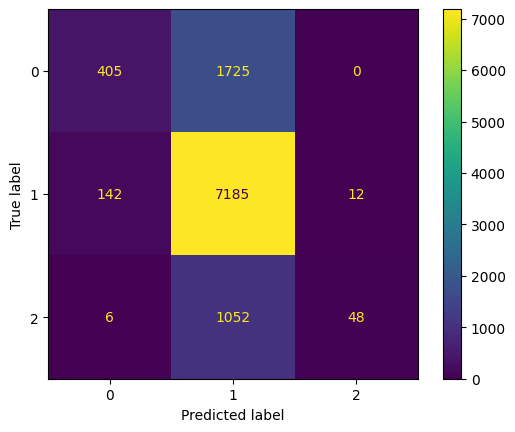

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)



---


Acurácia geral de 72%, mas grande desequilíbrio nos resultados por classe: Bom funcionamento apenas para a "classe 1".

A variância elevada em comparação com o viés também sinaliza algum grau de overfitting.

In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.72
Accuracy (TRAIN): 0.89
Viés: 0.06
Variância: 0.17


## Split (50% .. 25% .. 25%)

*   Treino:    50%
*   Validação: 25%
*   Teste:     25%






In [ ]:
# Separar X e y
X = ocorrencias_code.drop(['classificacao_acidente'], axis=1)

y = ocorrencias_code['classificacao_acidente']

# Dividir conjunto de teste (25%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=1/4, random_state=SEED)  # 75% temp (treino + validação), 25% teste

# Dividir conjunto de treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=SEED, stratify=y_temp)  # 50% treino, 25% validação, 25% teste

### RandomForest_unbalanced - 04



In [ ]:
# Distribuições
print("Distribuição das classes (TREINAMENTO):")
print(np.bincount(y_train))

print("Distribuição das classes (VALIDAÇÃO):")
print(np.bincount(y_val))

print("Distribuição das classes (TESTE):")
print(np.bincount(y_test))

Distribuição das classes (TREINAMENTO):
[1299 4795  690]
Distribuição das classes (VALIDAÇÃO):
[ 650 2398  344]
Distribuição das classes (TESTE):
[ 672 2404  317]


In [ ]:
# Iniciar um experimento
exp_name = 'RandomForest_unbalanced_04'
#experiment = client.get_experiment_by_name(exp_name)
#client.delete_experiment(experiment.experiment_id)
mlflow.set_experiment("RandomForest_unbalanced_04")

<Experiment: artifact_location='file:///content/drive/MyDrive/TCC/data/mlruns/252992404243502783', creation_time=1718972739158, experiment_id='252992404243502783', last_update_time=1718972739158, lifecycle_stage='active', name='RandomForest_unbalanced_04', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
      n_estimators = trial.suggest_int('n_estimators', 50, 300)
      max_depth = trial.suggest_int('max_depth', 10, 50)
      min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)

      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = RandomForestClassifier(
              criterion=criterion,
              n_estimators=n_estimators,
              max_depth=max_depth,
              min_samples_split=min_samples_split,
              min_samples_leaf=min_samples_leaf,
              random_state=SEED)
      model.fit(X_train, y_train)

      # Predições e cálculo de métricas
      predictions = model.predict(X_val)
      accuracy = accuracy_score(y_val, predictions)
      recall = recall_score(y_val, predictions, average='macro')
      precision = precision_score(y_val, predictions, average='macro')
      f1 = f1_score(y_val, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(model, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-06-28 19:48:25,518] A new study created in memory with name: no-name-51eb870f-41b6-41e5-898b-2d1eb2500c3d
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[I 2024-06-28 19:48:33,074] Trial 0 finished with value: 0.7550117924528302 and parameters: {'criterion': 'log_loss', 'n_estimators': 85, 'max_depth': 43, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7550117924528302.
[I 2024-06-28 19:48:38,489] Trial 1 finished with value: 0.7553066037735849 and parameters: {'criterion': 'gini', 'n_estimators': 170, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7553066037735849.
[I 2024-06-28 19:48:46,322] Trial 2 finished with value: 0.7520636792452831 and parameters: {'criterion': 'gini', 'n_estimators': 209, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial

KeyboardInterrupt: 

In [ ]:
ngrok.kill() # kill open tunnels
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLFlow Tracking UI:", ngrok_tunnel.public_url)

!mlflow ui

In [ ]:
# Configuração do cliente MLflow
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)

best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: 3cf1476beff94520a41a0029e9fe4314
Melhores Parâmetros:
criterion: gini
n_estimators: 294
max_depth: 41
min_samples_split: 10
min_samples_leaf: 1

Melhores Métricas:
accuracy: 0.7588443396226415
recall: 0.48365958911297086
precision: 0.7490535518244316
f1: 0.51774285651871


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.36      0.48       672
           1       0.77      0.96      0.85      2404
           2       0.67      0.13      0.22       317

    accuracy                           0.76      3393
   macro avg       0.72      0.48      0.52      3393
weighted avg       0.75      0.76      0.72      3393

Confusion Matrix:
[[ 240  432    0]
 [  85 2298   21]
 [   3  272   42]]
Accuracy by class:
Class 0: 35.71%
Class 1: 95.59%
Class 2: 13.25%


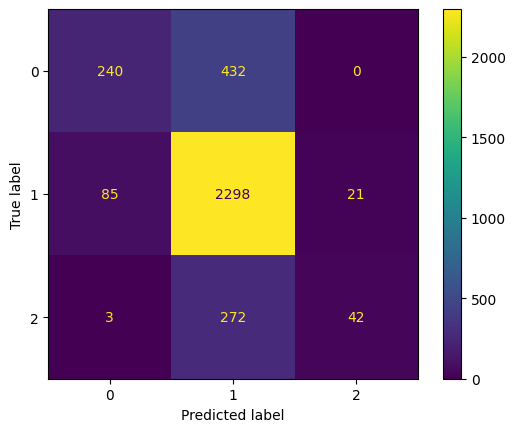

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)



---


Acurácia geral de 76% (melhora), mas ainda grande desequilíbrio nos resultados por classe: Bom funcionamento apenas para a "classe 1".

A variância elevada em comparação com o viés também sinaliza algum grau de overfitting.

In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.76
Accuracy (TRAIN): 0.90
Viés: 0.05
Variância: 0.14


## Balanceamento

In [ ]:
# Balanceamento
ros = RandomOverSampler(random_state=SEED)

# Aplicar o oversampling ao conjunto de treinamento
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
print("Distribuição das classes após o resampling (TREINAMENTO):")
print(np.bincount(y_train_balanced))

# Aplicar o oversampling ao conjunto de treinamento
X_val_balanced, y_val_balanced = ros.fit_resample(X_val, y_val)
print("Distribuição das classes após o resampling (VALIDAÇÃO):")
print(np.bincount(y_val_balanced))

# Checar o balanceamento das classes no conjunto de teste
print("Distribuição das classes no conjunto de TESTE:")
print(np.bincount(y_test))

Distribuição das classes após o resampling (TREINAMENTO):
[4795 4795 4795]
Distribuição das classes após o resampling (VALIDAÇÃO):
[2398 2398 2398]
Distribuição das classes no conjunto de TESTE:
[ 672 2404  317]


### RandomForest_balanced - 04



In [ ]:
exp_name = "gravidade_features1_RandomForest_balanced"

mlflow.set_experiment(exp_name)

2024/07/01 13:52:47 INFO mlflow.tracking.fluent: Experiment with name 'gravidade_features1_RandomForest_balanced' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/TCC/data/mlruns/309939716701610262', creation_time=1719841968299, experiment_id='309939716701610262', last_update_time=1719841968299, lifecycle_stage='active', name='gravidade_features1_RandomForest_balanced', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      criterion = 'log_loss' # trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
      n_estimators = trial.suggest_int('n_estimators', 40, 100) #50, 300)
      max_depth = trial.suggest_int('max_depth', 50, 100) #10, 50)
      min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)


      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = RandomForestClassifier(
              criterion=criterion,
              n_estimators=n_estimators,
              max_depth=max_depth,
              min_samples_split=min_samples_split,
              min_samples_leaf=min_samples_leaf,
              random_state=SEED)
      model.fit(X_train_balanced, y_train_balanced)

      # Predições e cálculo de métricas
      predictions = model.predict(X_val_balanced)
      accuracy = accuracy_score(y_val_balanced, predictions)
      recall = recall_score(y_val_balanced, predictions, average='macro')
      precision = precision_score(y_val_balanced, predictions, average='macro')
      f1 = f1_score(y_val_balanced, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(model, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-07-01 14:13:58,725] A new study created in memory with name: no-name-6d6212b0-513d-44cf-9cfd-a90d8a6fed09
[I 2024-07-01 14:14:13,724] Trial 0 finished with value: 0.555045871559633 and parameters: {'n_estimators': 53, 'max_depth': 96, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.555045871559633.
[I 2024-07-01 14:14:18,944] Trial 1 finished with value: 0.5539338337503475 and parameters: {'n_estimators': 59, 'max_depth': 83, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.555045871559633.
[I 2024-07-01 14:14:25,121] Trial 2 finished with value: 0.6166249652488185 and parameters: {'n_estimators': 51, 'max_depth': 84, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.6166249652488185.
[I 2024-07-01 14:14:29,974] Trial 3 finished with value: 0.6384487072560467 and parameters: {'n_estimators': 54, 'max_depth': 78, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.638

Melhores parâmetros: {'n_estimators': 92, 'max_depth': 72, 'min_samples_split': 9, 'min_samples_leaf': 8}
Melhor acurácia: 0.6608284681679177


In [ ]:
ngrok.kill() # kill open tunnels
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLFlow Tracking UI:", ngrok_tunnel.public_url)

!mlflow ui

In [ ]:
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)
best_run = runs[1]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: e2a65388fa9144ac873d7128abd275a8
Melhores Parâmetros:
criterion: log_loss
n_estimators: 121
max_depth: 45
min_samples_split: 8
min_samples_leaf: 8

Melhores Métricas:
accuracy: 0.6631915485126494
recall: 0.6631915485126494
precision: 0.6774221271919353
f1: 0.6633151764703853


In [ ]:
model = RandomForestClassifier(
              criterion='entropy',
              n_estimators=59,
              max_depth=29,
              min_samples_split=50,
              min_samples_leaf=8,
              random_state=42)
model.fit(X_train_balanced, y_train_balanced)



RandomForestClassifier(criterion='entropy', max_depth=29, min_samples_leaf=8,
                       min_samples_split=50, n_estimators=59, random_state=42)

AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.64
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.81      0.60       672
           1       0.89      0.59      0.71      2404
           2       0.32      0.65      0.43       317

    accuracy                           0.64      3393
   macro avg       0.56      0.68      0.58      3393
weighted avg       0.75      0.64      0.66      3393

Confusion Matrix:
[[ 546   90   36]
 [ 586 1412  406]
 [  31   81  205]]
Accuracy by class:
Class 0: 81.25%
Class 1: 58.74%
Class 2: 64.67%


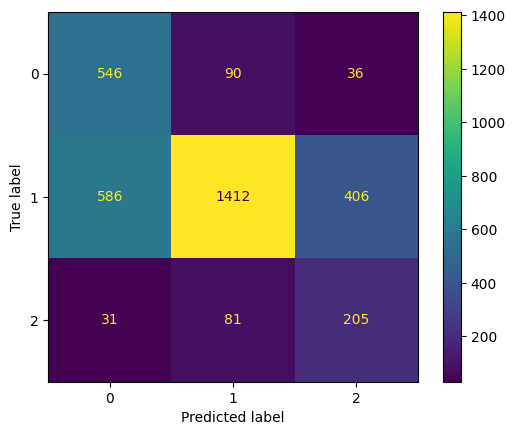

In [ ]:
# Melhor modelo
#model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
#model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)



---


Acurácia geral cai para 64%, mas como resultado de um maior equilíbrio entre as classes.

Viés e variância altas, necessitando melhorias.

In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.64
Accuracy (TRAIN): 0.84
Viés: 0.11
Variância: 0.20


### XGBoost_balanced

In [ ]:
exp_name = "XGBoost_balanced_04"
# Iniciar um experimento
mlflow.set_experiment(exp_name)

2024/06/28 20:33:36 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_balanced_04' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/MyDrive/TCC/data/mlruns/774755534598096292', creation_time=1719606816714, experiment_id='774755534598096292', last_update_time=1719606816714, lifecycle_stage='active', name='XGBoost_balanced_04', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      params = {
            #'objective': 'multi:softmax',  # Configuração para classificação multiclasse
            'objective': trial.suggest_categorical("objective", ["multi:softmax", "multi:softprob"]), # Configuração para classificação multiclasse
            'num_class': 3,                # Número de classes
            'tree_method': 'auto', #hist         # Método mais rápido para treinamento
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Regularização L2
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),    # Regularização L1
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0), # Reduzir para prevenir overfitting
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True), # Taxas de aprendizado mais baixas podem ser melhor
            'n_estimators': trial.suggest_int('n_estimators', 50, 600), #100, 600),  #RF: 50 a 300
            'max_depth': trial.suggest_int('max_depth', 10, 30), #3, 10),   # #RF: 10 a 30
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'eval_metric': ['mlogloss', 'merror'], #'eval_metric': 'mlogloss'
            'early_stopping_rounds': 50,
            'random_state': SEED
            }

      # Criar e treinar o modelo usando os parâmetros sugeridos
      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = xgb.XGBClassifier(**params)
      model.fit(X_train_balanced, y_train_balanced, eval_set=[(X_val_balanced, y_val_balanced)], verbose=False)

      # Predições e cálculo de métricas
      predictions = model.predict(X_val_balanced)
      accuracy = accuracy_score(y_val_balanced, predictions)
      recall = recall_score(y_val_balanced, predictions, average='macro')
      precision = precision_score(y_val_balanced, predictions, average='macro')
      f1 = f1_score(y_val_balanced, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(model, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      params = {
            #'objective': 'multi:softmax',  # Configuração para classificação multiclasse
            'objective': trial.suggest_categorical("objective", ["multi:softmax", "multi:softprob"]), # Configuração para classificação multiclasse
            'num_class': 3,                # Número de classes
            'tree_method': 'auto', #hist         # Método mais rápido para treinamento
            #'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Regularização L2
            #'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),    # Regularização L1
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0), # Reduzir para prevenir overfitting
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True), # Taxas de aprendizado mais baixas podem ser melhor
            'n_estimators': trial.suggest_int('n_estimators', 50, 600), #100, 600),  #RF: 50 a 300
            'max_depth': trial.suggest_int('max_depth', 10, 30), #3, 10),   # #RF: 10 a 30
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'eval_metric': 'mlogloss', #'eval_metric': 'mlogloss' ou 'merror'
            'early_stopping_rounds': 50,
            'random_state': SEED
            }

      # Criar e treinar o modelo usando os parâmetros sugeridos
      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = xgb.XGBClassifier(**params)
      model.fit(X_train_balanced, y_train_balanced, eval_set=[(X_val_balanced, y_val_balanced)], verbose=False)

      # Predições e cálculo de métricas
      predictions = model.predict(X_val_balanced)
      accuracy = accuracy_score(y_val_balanced, predictions)
      recall = recall_score(y_val_balanced, predictions, average='macro')
      precision = precision_score(y_val_balanced, predictions, average='macro')
      f1 = f1_score(y_val_balanced, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(model, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-06-28 20:52:53,075] A new study created in memory with name: no-name-bc624c9d-02ca-4cef-b7cd-45e0ef90b537
[I 2024-06-28 20:53:16,591] Trial 0 finished with value: 0.6455379482902419 and parameters: {'objective': 'multi:softmax', 'colsample_bytree': 0.5905770337413445, 'subsample': 0.5020217189959391, 'learning_rate': 0.00011644440550354917, 'n_estimators': 423, 'max_depth': 18, 'min_child_weight': 150}. Best is trial 0 with value: 0.6455379482902419.
[I 2024-06-28 20:53:31,312] Trial 1 finished with value: 0.6690297470113984 and parameters: {'objective': 'multi:softmax', 'colsample_bytree': 0.31382184695138254, 'subsample': 0.6590111906005964, 'learning_rate': 0.005218638567608889, 'n_estimators': 523, 'max_depth': 14, 'min_child_weight': 81}. Best is trial 1 with value: 0.6690297470113984.
[I 2024-06-28 20:53:45,240] Trial 2 finished with value: 0.6502641089797053 and parameters: {'objective': 'multi:softprob', 'colsample_bytree': 0.9711267370628913, 'subsample': 0.64488760552

Melhores parâmetros: {'objective': 'multi:softprob', 'colsample_bytree': 0.43007583088918544, 'subsample': 0.5977915956375706, 'learning_rate': 0.00016049684923345468, 'n_estimators': 248, 'max_depth': 11, 'min_child_weight': 22}
Melhor acurácia: 0.6719488462607729


In [ ]:
ngrok.kill() # kill open tunnels
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLFlow Tracking UI:", ngrok_tunnel.public_url)

!mlflow ui

In [ ]:
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)
best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: 9c7fa7ab795944feab1d64c76515e4f6
Melhores Parâmetros:
objective: multi:softprob
lambda: 2.7890611499875393e-05
alpha: 0.006585970455029584
colsample_bytree: 0.7438956142576049
subsample: 0.7239951361181945
learning_rate: 0.07220272088717712
n_estimators: 427
max_depth: 14
min_child_weight: 74

Melhores Métricas:
accuracy: 0.678621073116486
recall: 0.678621073116486
precision: 0.6780865466905354
f1: 0.6773015578158286


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.78      0.61       672
           1       0.88      0.59      0.70      2404
           2       0.28      0.67      0.40       317

    accuracy                           0.63      3393
   macro avg       0.56      0.68      0.57      3393
weighted avg       0.75      0.63      0.66      3393

Confusion Matrix:
[[ 521  106   45]
 [ 501 1411  492]
 [  22   82  213]]
Accuracy by class:
Class 0: 77.53%
Class 1: 58.69%
Class 2: 67.19%


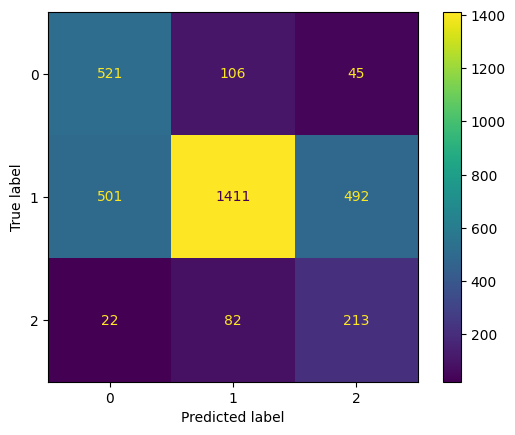

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)



---


Acurácia geral cai para 63% (menor que RF).

Viés e variância altos.


In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.63
Accuracy (TRAIN): 0.78
Viés: 0.17
Variância: 0.14


### SVM

In [ ]:
exp_name = "gravidade_svm_balanced"
# Iniciar um experimento
#experiment = client.get_experiment_by_name(exp_name)
#client.delete_experiment(experiment.experiment_id)
mlflow.set_experiment(exp_name)

<Experiment: artifact_location='file:///content/drive/MyDrive/TCC/data/mlruns/164633391324282192', creation_time=1719863171725, experiment_id='164633391324282192', last_update_time=1719863171725, lifecycle_stage='active', name='gravidade_svm_balanced', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros
      C = trial.suggest_float('C', 1e-3, 1e3, log=True)
      kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
      gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
      if kernel == 'poly':
          degree = trial.suggest_int('degree', 2, 5)

      # Montar o pipeline de preprocessamento e modelo
      model = Pipeline([
          ('scaler', StandardScaler()),  # Normalizar dados
          ('svm', SVC(C=C, kernel=kernel, gamma=gamma, degree=degree if kernel == 'poly' else 3, random_state=SEED, probability=True))
      ])

      # Treinando o modelo
      model.fit(X_train_balanced, y_train_balanced)

      # Predições e cálculo de métricas
      predictions = model.predict(X_val_balanced)
      accuracy = accuracy_score(y_val_balanced, predictions)
      recall = recall_score(y_val_balanced, predictions, average='macro')
      precision = precision_score(y_val_balanced, predictions, average='macro')
      f1 = f1_score(y_val_balanced, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(model, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-07-01 20:39:48,815] A new study created in memory with name: no-name-583bf561-2ce2-4aaa-85eb-ee19e3ef93d5
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[I 2024-07-01 20:43:14,899] Trial 0 finished with value: 0.6124548234639978 and parameters: {'C': 1.239233824643967, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.6124548234639978.


In [ ]:
ngrok.kill() # kill open tunnels
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLFlow Tracking UI:", ngrok_tunnel.public_url)

!mlflow ui

In [ ]:
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)
best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: 4cd73827638045cb90fe8c16dd7a6cf9
Melhores Parâmetros:
C: 0.05894912619213882
kernel: rbf
gamma: scale

Melhores Métricas:
accuracy: 0.613705865999444
recall: 0.613705865999444
precision: 0.6248655852657351
f1: 0.6037193972085918


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.53
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.85      0.52       672
           1       0.90      0.43      0.59      2404
           2       0.24      0.56      0.34       317

    accuracy                           0.53      3393
   macro avg       0.51      0.61      0.48      3393
weighted avg       0.73      0.53      0.55      3393

Confusion Matrix:
[[ 571   59   42]
 [ 857 1043  504]
 [  82   58  177]]
Accuracy by class:
Class 0: 84.97%
Class 1: 43.39%
Class 2: 55.84%


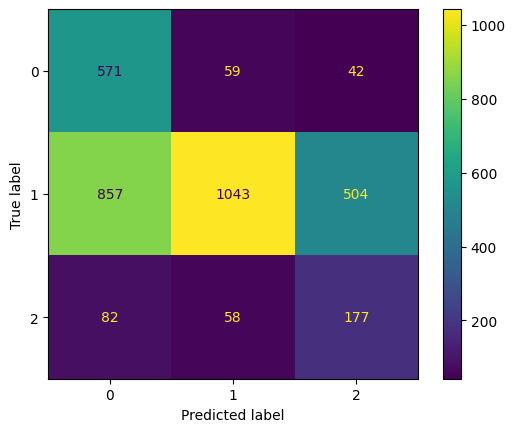

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)



---


Acurácia geral cai bastante para 53% (menor que RF).

Viés e variância altos.


In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.53
Accuracy (TRAIN): 0.65
Viés: 0.30
Variância: 0.12


### KNN

In [ ]:
exp_name = "gravidade_knn_balanced"
# Iniciar um experimento
#experiment = client.get_experiment_by_name(exp_name)
#client.delete_experiment(experiment.experiment_id)
mlflow.set_experiment(exp_name)

2024/07/06 09:30:43 INFO mlflow.tracking.fluent: Experiment with name 'gravidade_knn_balanced' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/546629832741116423', creation_time=1720258243884, experiment_id='546629832741116423', last_update_time=1720258243884, lifecycle_stage='active', name='gravidade_knn_balanced', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros
      n_neighbors = trial.suggest_int('n_neighbors', 3, 53)
      weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
      metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

      # Montar o pipeline de preprocessamento e modelo
      pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric))
      ])

      # Treinando o modelo
      pipeline.fit(X_train_balanced, y_train_balanced)

      # Predições e cálculo de métricas
      predictions = pipeline.predict(X_val_balanced)
      accuracy = accuracy_score(y_val_balanced, predictions)
      recall = recall_score(y_val_balanced, predictions, average='macro')
      precision = precision_score(y_val_balanced, predictions, average='macro')
      f1 = f1_score(y_val_balanced, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(pipeline, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-07-06 09:32:32,069] A new study created in memory with name: no-name-86f7f9d6-ee5e-4261-97b2-3e27a471f333
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[I 2024-07-06 09:32:47,118] Trial 0 finished with value: 0.6050875729774813 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.6050875729774813.
[I 2024-07-06 09:32:50,354] Trial 1 finished with value: 0.5921601334445371 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.6050875729774813.
[I 2024-07-06 09:32:54,130] Trial 2 finished with value: 0.5934111759799833 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.6050875729774813.
[I 2024-07-06 09:32:57,857] Trial 3 finished with value: 0.5346121768140116 and parameters: {

Melhores parâmetros: {'n_neighbors': 53, 'weights': 'distance', 'metric': 'manhattan'}
Melhor acurácia: 0.6127328329163192


In [ ]:
ngrok.kill() # kill open tunnels
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLFlow Tracking UI:", ngrok_tunnel.public_url)

!mlflow ui

MLFlow Tracking UI: https://26f0-104-199-210-156.ngrok-free.app
[2024-07-06 09:43:41 +0000] [12971] [INFO] Starting gunicorn 22.0.0
[2024-07-06 09:43:41 +0000] [12971] [INFO] Listening at: http://127.0.0.1:5000 (12971)
[2024-07-06 09:43:41 +0000] [12971] [INFO] Using worker: sync
[2024-07-06 09:43:41 +0000] [12972] [INFO] Booting worker with pid: 12972
[2024-07-06 09:43:41 +0000] [12973] [INFO] Booting worker with pid: 12973
[2024-07-06 09:43:41 +0000] [12974] [INFO] Booting worker with pid: 12974
[2024-07-06 09:43:41 +0000] [12975] [INFO] Booting worker with pid: 12975

[2024-07-06 09:44:37 +0000] [12971] [INFO] Handling signal: int
Aborted!
[2024-07-06 09:44:37 +0000] [12972] [INFO] Worker exiting (pid: 12972)
[2024-07-06 09:44:37 +0000] [12974] [INFO] Worker exiting (pid: 12974)
[2024-07-06 09:44:37 +0000] [12973] [INFO] Worker exiting (pid: 12973)
[2024-07-06 09:44:37 +0000] [12975] [INFO] Worker exiting (pid: 12975)
[2024-07-06 09:44:38 +0000] [12971] [INFO] Shutting down: Master


In [ ]:
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)
best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: b5e440a5c98942708d638a34ed4d41ea
Melhores Parâmetros:
metric: manhattan
weights: distance
n_neighbors: 53

Melhores Métricas:
precision: 0.611928231318971
accuracy: 0.6127328329163192
f1: 0.6101758495833065
recall: 0.6127328329163192


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.57
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.72      0.54       672
           1       0.88      0.52      0.65      2404
           2       0.23      0.62      0.34       317

    accuracy                           0.57      3393
   macro avg       0.51      0.62      0.51      3393
weighted avg       0.73      0.57      0.60      3393

Confusion Matrix:
[[ 484  102   86]
 [ 581 1248  575]
 [  45   74  198]]
Accuracy by class:
Class 0: 72.02%
Class 1: 51.91%
Class 2: 62.46%


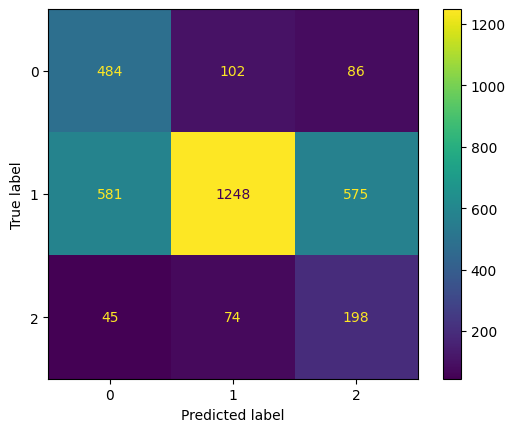

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)



---


Acurácia geral em 57% (menor que RF).

Modelo com overfit.


In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.57
Accuracy (TRAIN): 1.00
Viés: 0.00
Variância: 0.43


## One Hot Encoding

In [ ]:
# Reload dados e seleção de features
ocorrencias_code, ocorrencias = reload_checkpoint()

# Eliminar features redundantes e targets não utilizados
# manter 'classes_8' como feature substituta de 'causa_acidente'
cols = ['municipio', 'ano', 'mes', 'dia', 'trimestre', 'hora', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos',
        'classes_4', 'classes_4_bal', 'classes_2', 'classes_condutor']
ocorrencias = ocorrencias.drop(cols, axis=1)
ocorrencias_code = ocorrencias_code.drop(cols, axis=1)

In [ ]:
# Encoding
# Tripos categóricos
categoricos = ['dia_semana', 'br', 'tipo_acidente', 'classes_8', 'fase_dia',
               'sentido_via', 'condicao_metereologica', 'tipo_pista', 'uso_solo']

# Tranformar 'data_hora' em int (timestamp)
ocorrencias['data_hora'] = ocorrencias['data_hora'].astype('int64')/ 10**9  # De nanosegundo para segundo

numericos = ['data_hora', 'km', 'agricolas', 'automoveis', 'caminhoes', 'motocicletas',
       'nao_motorizados', 'onibus', 'reboques', 'veiculos_ignorados', '0-18', '19-28',
       '29-38', '39-48', '49-58', '59-68', '69-78', '79+', 'idade_ignorada', 'pedestres',
       'radar_1km']

# Pré-processador que aplica transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricos),
        ('num', StandardScaler(), numericos)
    ],
    remainder='passthrough'  # Mantém as outras variáveis como estão
)

In [ ]:
# Split
# Separar X e y
X = ocorrencias.drop(['classificacao_acidente'], axis=1)

encoder = LabelEncoder()
y = encoder.fit_transform(ocorrencias['classificacao_acidente'])
#y = ocorrencias['classificacao_acidente']

# Dividir conjunto de teste (25%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=1/4, random_state=SEED)  # 75% temp (treino + validação), 25% teste

# Dividir conjunto de treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=SEED, stratify=y_temp)  # 50% treino, 25% validação, 25% teste

In [ ]:
# Balanceamento
ros = RandomOverSampler(random_state=SEED)

# Aplicar o oversampling ao conjunto de treinamento
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
print("Distribuição das classes após o resampling (TREINAMENTO):")
print(np.bincount(y_train_balanced))

# Aplicar o oversampling ao conjunto de treinamento
X_val_balanced, y_val_balanced = ros.fit_resample(X_val, y_val)
print("Distribuição das classes após o resampling (VALIDAÇÃO):")
print(np.bincount(y_val_balanced))

# Checar o balanceamento das classes no conjunto de teste
print("Distribuição das classes no conjunto de TESTE:")
print(np.bincount(y_test))

Distribuição das classes após o resampling (TREINAMENTO):
[4795 4795 4795]
Distribuição das classes após o resampling (VALIDAÇÃO):
[2398 2398 2398]
Distribuição das classes no conjunto de TESTE:
[ 317 2404  672]


In [ ]:
ocorrencias.dtypes

data_hora                  float64
dia_semana                category
br                        category
km                         float64
tipo_acidente             category
classificacao_acidente    category
fase_dia                  category
sentido_via               category
condicao_metereologica    category
tipo_pista                category
uso_solo                  category
agricolas                    int64
automoveis                   int64
caminhoes                    int64
motocicletas                 int64
nao_motorizados              int64
onibus                       int64
reboques                     int64
veiculos_ignorados           int64
0-18                         int64
19-28                        int64
29-38                        int64
39-48                        int64
49-58                        int64
59-68                        int64
69-78                        int64
79+                          int64
idade_ignorada               int64
pedestres           

###KNN

In [ ]:
#!cp -r '/content/mlruns' '/content/drive/MyDrive'

In [ ]:
exp_name = "gravidade_knn_balanced_onehot"
# Iniciar um experimento
#experiment = client.get_experiment_by_name(exp_name)
#client.delete_experiment(experiment.experiment_id)
mlflow.set_experiment(exp_name)

2024/07/06 09:57:32 INFO mlflow.tracking.fluent: Experiment with name 'gravidade_knn_balanced_onehot' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/915589608203804316', creation_time=1720259852884, experiment_id='915589608203804316', last_update_time=1720259852884, lifecycle_stage='active', name='gravidade_knn_balanced_onehot', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros
      n_neighbors = trial.suggest_int('n_neighbors', 3, 113)
      weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
      metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

      # Montar o pipeline de preprocessamento e modelo
      pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('knn', KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric))
      ])

      # Treinando o modelo
      pipeline.fit(X_train_balanced, y_train_balanced)

      # Predições e cálculo de métricas
      predictions = pipeline.predict(X_val_balanced)
      accuracy = accuracy_score(y_val_balanced, predictions)
      recall = recall_score(y_val_balanced, predictions, average='macro')
      precision = precision_score(y_val_balanced, predictions, average='macro')
      f1 = f1_score(y_val_balanced, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(pipeline, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-07-06 10:06:20,304] A new study created in memory with name: no-name-1fd6b1ea-6a8f-4c9f-8c1a-4718425e2dcb
[I 2024-07-06 10:06:35,801] Trial 0 finished with value: 0.5892410341951626 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.5892410341951626.
[I 2024-07-06 10:06:39,230] Trial 1 finished with value: 0.6109257714762302 and parameters: {'n_neighbors': 73, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.6109257714762302.
[I 2024-07-06 10:06:43,645] Trial 2 finished with value: 0.601612454823464 and parameters: {'n_neighbors': 77, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.6109257714762302.
[I 2024-07-06 10:06:47,982] Trial 3 finished with value: 0.6035585209897136 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.6109257714762302.
[I 2024-07-06 10:06:51,717] Trial 4 finished with value: 0.61

Melhores parâmetros: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'manhattan'}
Melhor acurácia: 0.6490130664442592


In [ ]:
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)
best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: 2b89baacf0dd4d2b87c261154d62d618
Melhores Parâmetros:
metric: manhattan
weights: uniform
n_neighbors: 96

Melhores Métricas:
precision: 0.6451535550249848
accuracy: 0.6490130664442592
f1: 0.644924413612343
recall: 0.649013066444259


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.57
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.69      0.34       317
           1       0.88      0.51      0.65      2404
           2       0.46      0.72      0.56       672

    accuracy                           0.57      3393
   macro avg       0.52      0.64      0.52      3393
weighted avg       0.74      0.57      0.60      3393

Confusion Matrix:
[[ 218   69   30]
 [ 643 1228  533]
 [  89  100  483]]
Accuracy by class:
Class 0: 68.77%
Class 1: 51.08%
Class 2: 71.88%


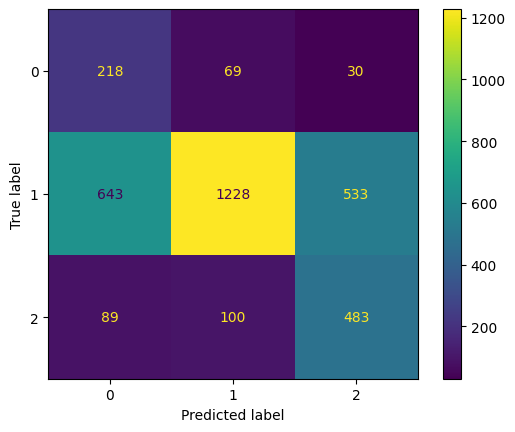

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)



---


Acurácia geral em 57% (menor que RF).

Não há mais overfit, mas viés e vairiância estão altos.


In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
accuracy_target = 0.85 # erro alvo de 15%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.57
Accuracy (TRAIN): 0.70
Viés: 0.15
Variância: 0.13


## Dataset Ampliado

In [ ]:
ocorrencias_code, ocorrencias = reload_checkpoint(amp=True)
ocorrencias.head()

,data_hora,ano,mes,dia,trimestre,hora,dia_semana,br,km,municipio,...,69-78,79+,idade_ignorada,pedestres,radar_1km,classes_4,classes_8,classes_4_bal,classes_2,classes_condutor
0,2017-01-01 15:55:00,2017,1,1,1,15.916667,domingo,101,62.8,RECIFE,...,0,0,0,1,1,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Outros
1,2017-01-01 22:00:00,2017,1,1,1,22.000000,domingo,232,142.0,SAO CAITANO,...,0,0,2,0,0,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
2,2017-01-01 21:30:00,2017,1,1,1,21.500000,domingo,232,84.7,GRAVATA,...,0,0,0,0,0,Fatores Naturais,Fatores Naturais,Fatores Externos,Fator Externo,Outros
3,2017-01-02 06:30:00,2017,1,2,1,6.500000,segunda-feira,101,23.0,GOIANA,...,0,0,0,0,0,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
4,2017-01-02 13:50:00,2017,1,2,1,13.833333,segunda-feira,101,73.2,RECIFE,...,0,0,0,0,3,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor


In [ ]:
# Eliminar features redundantes e targets não utilizados
# manter 'classes_8' como feature substituta de 'causa_acidente'
cols = ['ano', 'mes', 'dia', 'trimestre', 'hora', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos',
        'classes_4', 'classes_4_bal', 'classes_2', 'classes_condutor']
ocorrencias = ocorrencias.drop(cols, axis=1)
ocorrencias_code = ocorrencias_code.drop(cols, axis=1)

In [ ]:
# Separar X e y
X = ocorrencias_code.drop(['classificacao_acidente'], axis=1)

y = ocorrencias_code['classificacao_acidente']

# Dividir conjunto de teste (25%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=1/4, random_state=SEED)  # 75% temp (treino + validação), 25% teste

# Dividir conjunto de treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=SEED, stratify=y_temp)  # 50% treino, 25% validação, 25% teste

In [ ]:
# Balanceamento
ros = RandomOverSampler(random_state=SEED)

# Aplicar o oversampling ao conjunto de treinamento
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
print("Distribuição das classes após o resampling (TREINAMENTO):")
print(np.bincount(y_train_balanced))

# Aplicar o oversampling ao conjunto de treinamento
X_val_balanced, y_val_balanced = ros.fit_resample(X_val, y_val)
print("Distribuição das classes após o resampling (VALIDAÇÃO):")
print(np.bincount(y_val_balanced))

# Checar o balanceamento das classes no conjunto de teste
print("Distribuição das classes no conjunto de TESTE:")
print(np.bincount(y_test))

Distribuição das classes após o resampling (TREINAMENTO):
[6653 6653 6653]
Distribuição das classes após o resampling (VALIDAÇÃO):
[3326 3326 3326]
Distribuição das classes no conjunto de TESTE:
[1160 3291  479]


### RandomForest_balanced - ampliado



In [ ]:
exp_name = "gravidade_ampliado_RandomForest_balanced"
mlflow.set_experiment(exp_name)

2024/07/07 00:12:30 INFO mlflow.tracking.fluent: Experiment with name 'gravidade_ampliado_RandomForest_balanced' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/822165400852779334', creation_time=1720311150607, experiment_id='822165400852779334', last_update_time=1720311150607, lifecycle_stage='active', name='gravidade_ampliado_RandomForest_balanced', tags={}>

In [ ]:
# Modelo com os melhores parâmetros obtidos anteriormente
model = RandomForestClassifier(
            criterion='entropy',
            n_estimators=59,
            max_depth=29,
            min_samples_split=50,
            min_samples_leaf=8,
            random_state=42)
model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(criterion='entropy', max_depth=29, min_samples_leaf=8,
                       min_samples_split=50, n_estimators=59, random_state=42)

In [ ]:
# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.85      0.62      1160
           1       0.87      0.56      0.68      3291
           2       0.34      0.56      0.42       479

    accuracy                           0.63      4930
   macro avg       0.57      0.66      0.58      4930
weighted avg       0.73      0.63      0.64      4930





---

Acima, utilizamos os mesmos hiperparâmetros do melhor modelo obtido anteriormente e executamos o treinamento com o dataset ampliado.

Os resultados, contudo, não melhoraram, ocorrendo uma discreta piora na acurácia geral.

Abaixo, vamos realizar novo treinamento usando o optuna.

---



In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
      n_estimators = trial.suggest_int('n_estimators', 40, 300)
      max_depth = trial.suggest_int('max_depth', 10, 100) #10, 50)
      min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)


      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = RandomForestClassifier(
              criterion=criterion,
              n_estimators=n_estimators,
              max_depth=max_depth,
              min_samples_split=min_samples_split,
              min_samples_leaf=min_samples_leaf,
              random_state=SEED)
      model.fit(X_train_balanced, y_train_balanced)

      # Predições e cálculo de métricas
      predictions = model.predict(X_val_balanced)
      accuracy = accuracy_score(y_val_balanced, predictions)
      recall = recall_score(y_val_balanced, predictions, average='macro')
      precision = precision_score(y_val_balanced, predictions, average='macro')
      f1 = f1_score(y_val_balanced, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(model, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-07-07 00:30:48,995] A new study created in memory with name: no-name-70b8c170-9f2d-45a6-b385-6cde1824b7b4
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[I 2024-07-07 00:31:07,421] Trial 0 finished with value: 0.6626578472639808 and parameters: {'criterion': 'log_loss', 'n_estimators': 171, 'max_depth': 61, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6626578472639808.
[I 2024-07-07 00:31:19,625] Trial 1 finished with value: 0.652635798757266 and parameters: {'criterion': 'log_loss', 'n_estimators': 270, 'max_depth': 88, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6626578472639808.
[I 2024-07-07 00:31:31,617] Trial 2 finished with value: 0.653337342152736 and parameters: {'criterion': 'log_loss', 'n_estimators': 261, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best i

Melhores parâmetros: {'criterion': 'log_loss', 'n_estimators': 298, 'max_depth': 80, 'min_samples_split': 4, 'min_samples_leaf': 7}
Melhor acurácia: 0.6667668871517338


In [ ]:
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)
best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: b164cfe6d5bb4c0a9c7a9cfa523c4411
Melhores Parâmetros:
min_samples_split: 4
criterion: log_loss
max_depth: 80
min_samples_leaf: 7
n_estimators: 298

Melhores Métricas:
precision: 0.6863069084105685
accuracy: 0.6667668871517338
f1: 0.662444145058784
recall: 0.6667668871517338


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.82      0.63      1160
           1       0.86      0.63      0.72      3291
           2       0.38      0.49      0.43       479

    accuracy                           0.66      4930
   macro avg       0.58      0.65      0.59      4930
weighted avg       0.73      0.66      0.67      4930

Confusion Matrix:
[[ 956  176   28]
 [ 855 2070  366]
 [  67  175  237]]
Accuracy by class:
Class 0: 82.41%
Class 1: 62.90%
Class 2: 49.48%


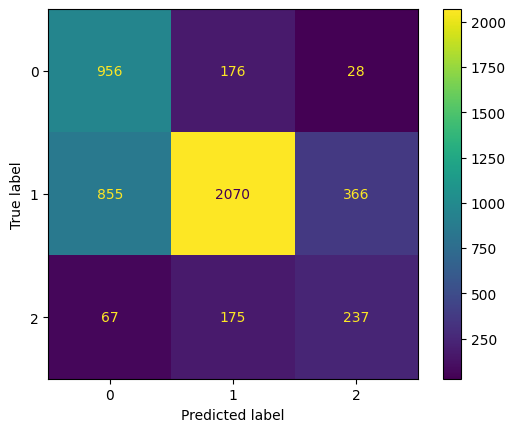

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)



---

Com o novo modelo obtivemos melhora na acurácia geral, passando de 64% para 66%.



---



In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.66
Accuracy (TRAIN): 0.90
Viés: 0.05
Variância: 0.24


#CLASSES_CONDUTOR (target)
```
classes_condutor
0  Condutor    10044
1  Outros       3525
```

Numa outra abordagem, escolhemos como **target** o atributo **`'classes_condutor'`**.


> Coluna obtida da transformação do atributo '**causa_acidente**', indicando se a ocorrência foi causada pelo *condutor* ou por *outros* fatores.

Como o modelo de melhor performance nos testes anteriores foi o **Random Forest**, vamos utilizá-lo neste experimento.

Treinamos os modelos utilizando 3 abordagens:
1. Usando crossvalidation (sem balanceamento de dados)
2. Com conjuntos de treinamento e validação SEM balanceamento de dados
3. Com conjuntos de treinamento e validação COM balanceamento de dados **[RESULTADOS MAIS EQUILIBRADOS]**


Para tentar aprimorar o modelo, ampliamos o dataset (acrescentando os dados de mais dois anos de ocorrências: 2017 e 2018) e realizamos novos treinamentos, obtendo discreta melhora.

## Seleção de features e target

In [ ]:
ocorrencias_code, ocorrencias = reload_checkpoint()
ocorrencias.columns

Index(['data_hora', 'ano', 'mes', 'dia', 'trimestre', 'hora', 'dia_semana',
       'br', 'km', 'municipio', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'uso_solo', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves',
       'ilesos', 'ignorados', 'feridos', 'veiculos', 'agricolas', 'automoveis',
       'caminhoes', 'motocicletas', 'nao_motorizados', 'onibus', 'reboques',
       'veiculos_ignorados', '0-18', '19-28', '29-38', '39-48', '49-58',
       '59-68', '69-78', '79+', 'idade_ignorada', 'pedestres', 'radar_1km',
       'classes_4', 'classes_8', 'classes_4_bal', 'classes_2',
       'classes_condutor'],
      dtype='object')

In [ ]:
# Eliminar features redundantes e targets não utilizados
cols = ['ano', 'mes', 'dia', 'trimestre', 'hora', 'pessoas', 'feridos', 'veiculos',
        'classes_4', 'classes_8', 'classes_4_bal', 'classes_2']
ocorrencias = ocorrencias.drop(cols, axis=1)
ocorrencias_code = ocorrencias_code.drop(cols, axis=1)

## Split (2023 .. Demais anos)

*   Teste:       2023
*   Treinamento: Demais anos



In [ ]:
# Datetime para inicio de 2023
start_2023 = datetime.datetime(year=2023, month=1, day=1, hour=0, minute=0, second=0)
start_2023_seconds = int(start_2023.timestamp())

# proporção de ocorrencias 2023
len_test = len(ocorrencias_code[ocorrencias_code.data_hora >= start_2023_seconds])
len_train = len(ocorrencias_code[ocorrencias_code.data_hora < start_2023_seconds])
print(len_test / (len_train + len_test))

0.22065001105460977


In [ ]:
# Separar X e y (Treino e teste) => Teste (ano de 2023) e Treino (Demais anos)
X = ocorrencias_code.drop(['classes_condutor'], axis=1)
X_train = X[X.data_hora >= start_2023_seconds]
X_test = X[X.data_hora < start_2023_seconds]

y_train = ocorrencias_code[ocorrencias_code.data_hora >= start_2023_seconds]['classes_condutor']
y_test = ocorrencias_code[ocorrencias_code.data_hora < start_2023_seconds]['classes_condutor']

### RandomForest_unbalanced_crosval - 05

In [ ]:
# Iniciar um experimento
exp_name = 'RandomForest_condutor_unbalanced_crossval_05'
#experiment = client.get_experiment_by_name(exp_name)
#client.delete_experiment(experiment.experiment_id)
mlflow.set_experiment(exp_name)

<Experiment: artifact_location='file:///content/drive/MyDrive/TCC/data/mlruns/157807362562730449', creation_time=1719133907038, experiment_id='157807362562730449', last_update_time=1719133907038, lifecycle_stage='active', name='RandomForest_condutor_unbalanced_crossval_05', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
      n_estimators = trial.suggest_int('n_estimators', 50, 300)
      max_depth = trial.suggest_int('max_depth', 10, 50)
      min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)

      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = RandomForestClassifier(
              criterion=criterion,
              n_estimators=n_estimators,
              max_depth=max_depth,
              min_samples_split=min_samples_split,
              min_samples_leaf=min_samples_leaf,
              random_state=SEED)

      # Usar a validação cruzada estratificada com múltiplas métricas
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
      metrics = {'accuracy': make_scorer(accuracy_score),
                  'precision': make_scorer(precision_score, average='macro'),
                  'recall': make_scorer(recall_score, average='macro'),
                  'f1_score': make_scorer(f1_score, average='macro')}
      results = cross_validate(model, X_train, y_train, cv=skf, scoring=metrics)

      # Treinar o modelo no conjunto completo para salvá-lo ajustado
      model.fit(X_train, y_train)

      # Calcular a média das métricas
      mean_accuracy = results['test_accuracy'].mean()
      mean_precision = results['test_precision'].mean()
      mean_recall = results['test_recall'].mean()
      mean_f1 = results['test_f1_score'].mean()

      # Logar parâmetros e métricas no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metrics({
          'mean_accuracy': mean_accuracy,
          'mean_precision': mean_precision,
          'mean_recall': mean_recall,
          'mean_f1': mean_f1
      })
      mlflow.sklearn.log_model(model, "model")

      return mean_accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-06-23 09:14:40,295] A new study created in memory with name: no-name-633e77f5-84bc-40c6-8091-084e4ae41016
[I 2024-06-23 09:14:49,326] Trial 0 finished with value: 0.8303264638388395 and parameters: {'criterion': 'log_loss', 'n_estimators': 251, 'max_depth': 48, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8303264638388395.
[I 2024-06-23 09:14:58,926] Trial 1 finished with value: 0.831663139792631 and parameters: {'criterion': 'gini', 'n_estimators': 238, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.831663139792631.
[I 2024-06-23 09:15:11,387] Trial 2 finished with value: 0.8393420472247503 and parameters: {'criterion': 'entropy', 'n_estimators': 279, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8393420472247503.
[I 2024-06-23 09:15:16,550] Trial 3 finished with value: 0.8376720397987729 and parameters: {'criterion': 'entropy', 'n_estimators': 69, 

Melhores parâmetros: {'criterion': 'entropy', 'n_estimators': 188, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1}
Melhor acurácia: 0.8426826204208797


In [ ]:
ngrok.kill() # kill open tunnels
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLFlow Tracking UI:", ngrok_tunnel.public_url)

!mlflow ui

MLFlow Tracking UI: https://0801-35-196-240-150.ngrok-free.app
[2024-06-20 16:55:50 +0000] [79390] [INFO] Starting gunicorn 22.0.0
[2024-06-20 16:55:50 +0000] [79390] [INFO] Listening at: http://127.0.0.1:5000 (79390)
[2024-06-20 16:55:50 +0000] [79390] [INFO] Using worker: sync
[2024-06-20 16:55:50 +0000] [79391] [INFO] Booting worker with pid: 79391
[2024-06-20 16:55:50 +0000] [79392] [INFO] Booting worker with pid: 79392
[2024-06-20 16:55:50 +0000] [79397] [INFO] Booting worker with pid: 79397
[2024-06-20 16:55:51 +0000] [79398] [INFO] Booting worker with pid: 79398

Aborted!
[2024-06-20 16:58:28 +0000] [79390] [INFO] Handling signal: int
[2024-06-20 16:58:28 +0000] [79392] [INFO] Worker exiting (pid: 79392)
[2024-06-20 16:58:28 +0000] [79397] [INFO] Worker exiting (pid: 79397)
[2024-06-20 16:58:28 +0000] [79391] [INFO] Worker exiting (pid: 79391)
[2024-06-20 16:58:28 +0000] [79398] [INFO] Worker exiting (pid: 79398)
[2024-06-20 16:58:29 +0000] [79390] [INFO] Shutting down: Master


In [ ]:
# Acessar o experimento pelo nome
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)
best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: 31170bc4b9b14eccb2a3bdaaeecd5a01
Melhores Parâmetros:
criterion: log_loss
n_estimators: 156
max_depth: 18
min_samples_split: 3
min_samples_leaf: 3

Melhores Métricas:
mean_accuracy: 0.8360003573402717
mean_precision: 0.8124928143633319
mean_recall: 0.716006427773329
mean_f1: 0.7439289937344117


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7793
           1       0.75      0.50      0.60      2782

    accuracy                           0.82     10575
   macro avg       0.79      0.72      0.74     10575
weighted avg       0.82      0.82      0.81     10575

Confusion Matrix:
[[7330  463]
 [1403 1379]]
Accuracy by class:
Class 0: 94.06%
Class 1: 49.57%


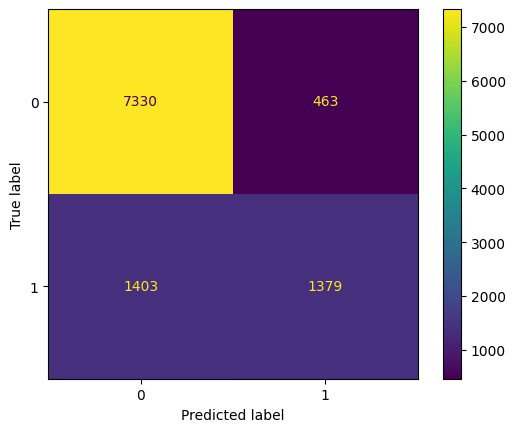

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)


---

Acurácia geral de 82%, mas há acentuado desequilíbrio nos resultados por classe. Para a "classe 1", menos de 50% acertos.

A variância elevada em comparação com o viés também sinaliza algum grau de overfitting.

In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.82
Accuracy (TRAIN): 0.93
Viés: 0.02
Variância: 0.11


## Split (50% .. 25% .. 25%)

*   Treino:    50%
*   Validação: 25%
*   Teste:     25%

In [ ]:
# Separar X e y
X = ocorrencias_code.drop(['classes_condutor'], axis=1)

y = ocorrencias_code['classes_condutor']

# Dividir conjunto de teste (25%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=1/4, random_state=SEED)  # 75% temp (treino + validação), 25% teste

# Dividir conjunto de treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=SEED, stratify=y_temp)  # 50% treino, 25% validação, 25% teste

### RandomForest_unbalanced - 05



In [ ]:
# Distribuições
print("Distribuição das classes (TREINAMENTO):")
print(np.bincount(y_train))

print("Distribuição das classes (VALIDAÇÃO):")
print(np.bincount(y_val))

print("Distribuição das classes (TESTE):")
print(np.bincount(y_test))

Distribuição das classes (TREINAMENTO):
[5031 1753]
Distribuição das classes (VALIDAÇÃO):
[2516  876]
Distribuição das classes (TESTE):
[2497  896]


In [ ]:
# Iniciar um experimento
exp_name = "RandomForest_condutor_unbalanced_05"
mlflow.set_experiment(exp_name)

<Experiment: artifact_location='file:///content/drive/MyDrive/TCC/data/mlruns/358545429874678056', creation_time=1719132659586, experiment_id='358545429874678056', last_update_time=1719132659586, lifecycle_stage='active', name='RandomForest_condutor_unbalanced_05', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
      n_estimators = trial.suggest_int('n_estimators', 50, 300)
      max_depth = trial.suggest_int('max_depth', 10, 50)
      min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)

      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = RandomForestClassifier(
              criterion=criterion,
              n_estimators=n_estimators,
              max_depth=max_depth,
              min_samples_split=min_samples_split,
              min_samples_leaf=min_samples_leaf,
              random_state=SEED)
      model.fit(X_train, y_train)

      # Predições e cálculo de métricas
      predictions = model.predict(X_val)
      accuracy = accuracy_score(y_val, predictions)
      recall = recall_score(y_val, predictions, average='macro')
      precision = precision_score(y_val, predictions, average='macro')
      f1 = f1_score(y_val, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(model, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-06-23 08:51:24,771] A new study created in memory with name: no-name-9ef59edc-ff3b-4420-acf5-b4cf4159a676
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[I 2024-06-23 08:51:32,635] Trial 0 finished with value: 0.8428655660377359 and parameters: {'criterion': 'entropy', 'n_estimators': 107, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8428655660377359.
[I 2024-06-23 08:51:37,405] Trial 1 finished with value: 0.8369693396226415 and parameters: {'criterion': 'gini', 'n_estimators': 92, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8428655660377359.
[I 2024-06-23 08:51:42,755] Trial 2 finished with value: 0.8337264150943396 and parameters: {'criterion': 'entropy', 'n_estimators': 178, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is tri

Melhores parâmetros: {'criterion': 'entropy', 'n_estimators': 90, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 5}
Melhor acurácia: 0.8431603773584906


In [ ]:
ngrok.kill() # kill open tunnels
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLFlow Tracking UI:", ngrok_tunnel.public_url)

!mlflow ui

MLFlow Tracking UI: https://0801-35-196-240-150.ngrok-free.app
[2024-06-20 16:55:50 +0000] [79390] [INFO] Starting gunicorn 22.0.0
[2024-06-20 16:55:50 +0000] [79390] [INFO] Listening at: http://127.0.0.1:5000 (79390)
[2024-06-20 16:55:50 +0000] [79390] [INFO] Using worker: sync
[2024-06-20 16:55:50 +0000] [79391] [INFO] Booting worker with pid: 79391
[2024-06-20 16:55:50 +0000] [79392] [INFO] Booting worker with pid: 79392
[2024-06-20 16:55:50 +0000] [79397] [INFO] Booting worker with pid: 79397
[2024-06-20 16:55:51 +0000] [79398] [INFO] Booting worker with pid: 79398

Aborted!
[2024-06-20 16:58:28 +0000] [79390] [INFO] Handling signal: int
[2024-06-20 16:58:28 +0000] [79392] [INFO] Worker exiting (pid: 79392)
[2024-06-20 16:58:28 +0000] [79397] [INFO] Worker exiting (pid: 79397)
[2024-06-20 16:58:28 +0000] [79391] [INFO] Worker exiting (pid: 79391)
[2024-06-20 16:58:28 +0000] [79398] [INFO] Worker exiting (pid: 79398)
[2024-06-20 16:58:29 +0000] [79390] [INFO] Shutting down: Master


In [ ]:
# Configuração do cliente MLflow
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)

best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: 90793ff374f347a6b6db2ce53566ee64
Melhores Parâmetros:
criterion: entropy
n_estimators: 90
max_depth: 25
min_samples_split: 2
min_samples_leaf: 5

Melhores Métricas:
accuracy: 0.8431603773584906
recall: 0.7376443728176203
precision: 0.8274565556080715
f1: 0.7657398959700197


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2497
           1       0.77      0.48      0.59       896

    accuracy                           0.82      3393
   macro avg       0.80      0.71      0.74      3393
weighted avg       0.82      0.82      0.81      3393

Confusion Matrix:
[[2365  132]
 [ 466  430]]
Accuracy by class:
Class 0: 94.71%
Class 1: 47.99%


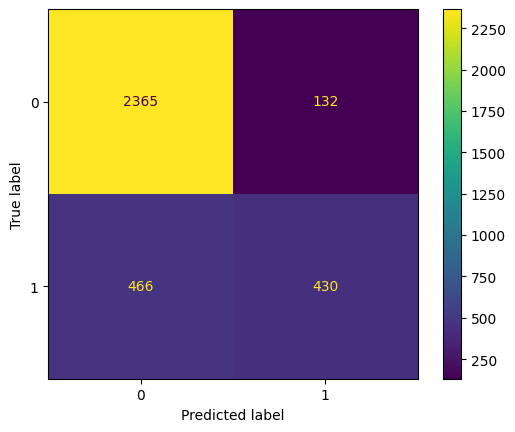

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)


---

Acurácia geral manteve-se em 82%, aina com o mesmo desequilíbrio nos resultados por classe. Para a "classe 1", menos de 50% acertos.

Houve melhora na variância.

In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.82
Accuracy (TRAIN): 0.88
Viés: 0.07
Variância: 0.06


### RandomForest_balanced - 05



In [ ]:
# Balanceamento
ros = RandomOverSampler(random_state=SEED)

# Aplicar o oversampling ao conjunto de treinamento
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
print("Distribuição das classes após o resampling (TREINAMENTO):")
print(np.bincount(y_train_balanced))

# Aplicar o oversampling ao conjunto de treinamento
X_val_balanced, y_val_balanced = ros.fit_resample(X_val, y_val)
print("Distribuição das classes após o resampling (VALIDAÇÃO):")
print(np.bincount(y_val_balanced))

# Checar o balanceamento das classes no conjunto de teste
print("Distribuição das classes no conjunto de TESTE:")
print(np.bincount(y_test))

Distribuição das classes após o resampling (TREINAMENTO):
[5031 5031]
Distribuição das classes após o resampling (VALIDAÇÃO):
[2516 2516]
Distribuição das classes no conjunto de TESTE:
[2497  896]


In [ ]:
exp_name = "RandomForest_condutor_balanced_05"
#experiment = client.get_experiment_by_name(exp_name)
#client.delete_experiment(experiment.experiment_id)
mlflow.set_experiment(exp_name)

<Experiment: artifact_location='file:///content/drive/MyDrive/TCC/data/mlruns/931924998012643541', creation_time=1719133390253, experiment_id='931924998012643541', last_update_time=1719133390253, lifecycle_stage='active', name='RandomForest_condutor_balanced_05', tags={}>

In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
      n_estimators = trial.suggest_int('n_estimators', 50, 300)
      max_depth = trial.suggest_int('max_depth', 10, 50)
      min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)

      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = RandomForestClassifier(
              criterion=criterion,
              n_estimators=n_estimators,
              max_depth=max_depth,
              min_samples_split=min_samples_split,
              min_samples_leaf=min_samples_leaf,
              random_state=SEED)
      model.fit(X_train_balanced, y_train_balanced)

      # Predições e cálculo de métricas
      predictions = model.predict(X_val_balanced)
      accuracy = accuracy_score(y_val_balanced, predictions)
      recall = recall_score(y_val_balanced, predictions, average='macro')
      precision = precision_score(y_val_balanced, predictions, average='macro')
      f1 = f1_score(y_val_balanced, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(model, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-06-23 09:03:42,878] A new study created in memory with name: no-name-93d201e3-e3f9-4412-b008-74c1f320299d
[I 2024-06-23 09:03:51,321] Trial 0 finished with value: 0.7766295707472178 and parameters: {'criterion': 'entropy', 'n_estimators': 289, 'max_depth': 44, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7766295707472178.
[I 2024-06-23 09:04:03,140] Trial 1 finished with value: 0.784181240063593 and parameters: {'criterion': 'entropy', 'n_estimators': 188, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.784181240063593.
[I 2024-06-23 09:04:11,931] Trial 2 finished with value: 0.7724562798092209 and parameters: {'criterion': 'gini', 'n_estimators': 97, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.784181240063593.
[I 2024-06-23 09:04:23,445] Trial 3 finished with value: 0.7670906200317965 and parameters: {'criterion': 'gini', 'n_estimators': 186, 'ma

Melhores parâmetros: {'criterion': 'gini', 'n_estimators': 186, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 3}
Melhor acurácia: 0.7861685214626392


In [ ]:
ngrok.kill() # kill open tunnels
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLFlow Tracking UI:", ngrok_tunnel.public_url)

!mlflow ui

MLFlow Tracking UI: https://0801-35-196-240-150.ngrok-free.app
[2024-06-20 16:55:50 +0000] [79390] [INFO] Starting gunicorn 22.0.0
[2024-06-20 16:55:50 +0000] [79390] [INFO] Listening at: http://127.0.0.1:5000 (79390)
[2024-06-20 16:55:50 +0000] [79390] [INFO] Using worker: sync
[2024-06-20 16:55:50 +0000] [79391] [INFO] Booting worker with pid: 79391
[2024-06-20 16:55:50 +0000] [79392] [INFO] Booting worker with pid: 79392
[2024-06-20 16:55:50 +0000] [79397] [INFO] Booting worker with pid: 79397
[2024-06-20 16:55:51 +0000] [79398] [INFO] Booting worker with pid: 79398

Aborted!
[2024-06-20 16:58:28 +0000] [79390] [INFO] Handling signal: int
[2024-06-20 16:58:28 +0000] [79392] [INFO] Worker exiting (pid: 79392)
[2024-06-20 16:58:28 +0000] [79397] [INFO] Worker exiting (pid: 79397)
[2024-06-20 16:58:28 +0000] [79391] [INFO] Worker exiting (pid: 79391)
[2024-06-20 16:58:28 +0000] [79398] [INFO] Worker exiting (pid: 79398)
[2024-06-20 16:58:29 +0000] [79390] [INFO] Shutting down: Master


In [ ]:
# Acessar o experimento pelo nome
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)

best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: c1b74c90e05e4084aef0bf0c40c738d8
Melhores Parâmetros:
criterion: gini
n_estimators: 186
max_depth: 10
min_samples_split: 9
min_samples_leaf: 3

Melhores Métricas:
accuracy: 0.7861685214626392
recall: 0.786168521462639
precision: 0.788796324874184
f1: 0.7856809908268967


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.86      2497
           1       0.59      0.72      0.65       896

    accuracy                           0.80      3393
   macro avg       0.74      0.77      0.75      3393
weighted avg       0.81      0.80      0.80      3393

Confusion Matrix:
[[2058  439]
 [ 252  644]]
Accuracy by class:
Class 0: 82.42%
Class 1: 71.88%


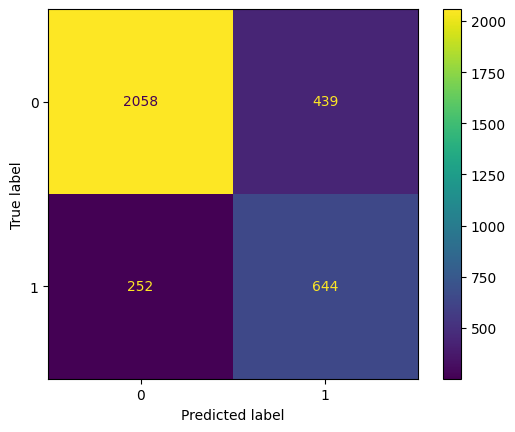

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)


---

Acurácia geral tem leve redução para 80%, havendo maior equilíbrio nos resultados por classe.

Ainda apresenta um viés elevado.

In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.80
Accuracy (TRAIN): 0.85
Viés: 0.10
Variância: 0.05


#### PFI

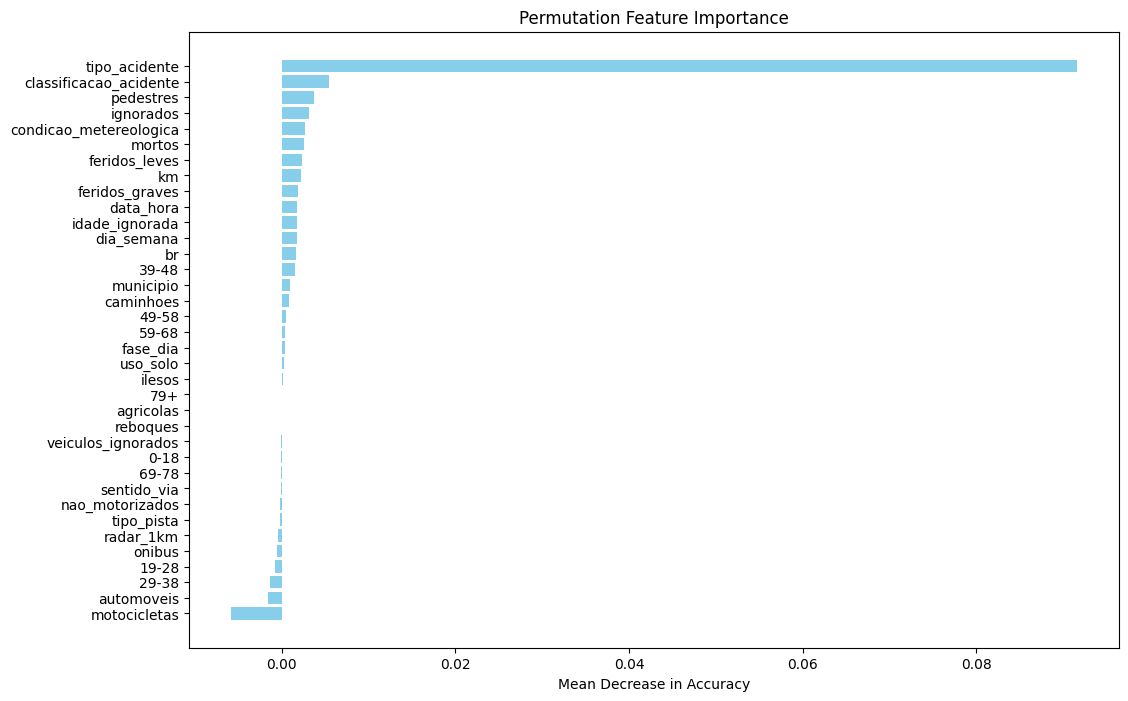

In [ ]:
# Calcular PFI
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=SEED, n_jobs=2)

# Extract the importance scores and feature names
feature_importances = result.importances_mean
feature_names = X_test.columns

# Create a DataFrame for easy plotting
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the Feature Importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

## Dataset Ampliado

In [ ]:
ocorrencias_code, ocorrencias = reload_checkpoint(amp=True)
ocorrencias.head()

,data_hora,ano,mes,dia,trimestre,hora,dia_semana,br,km,municipio,...,69-78,79+,idade_ignorada,pedestres,radar_1km,classes_4,classes_8,classes_4_bal,classes_2,classes_condutor
0,2017-01-01 15:55:00,2017,1,1,1,15.916667,domingo,101,62.8,RECIFE,...,0,0,0,1,1,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Outros
1,2017-01-01 22:00:00,2017,1,1,1,22.000000,domingo,232,142.0,SAO CAITANO,...,0,0,2,0,0,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
2,2017-01-01 21:30:00,2017,1,1,1,21.500000,domingo,232,84.7,GRAVATA,...,0,0,0,0,0,Fatores Naturais,Fatores Naturais,Fatores Externos,Fator Externo,Outros
3,2017-01-02 06:30:00,2017,1,2,1,6.500000,segunda-feira,101,23.0,GOIANA,...,0,0,0,0,0,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor
4,2017-01-02 13:50:00,2017,1,2,1,13.833333,segunda-feira,101,73.2,RECIFE,...,0,0,0,0,3,Fator Humano,Atenção ou Reação Ineficientes,Atenção ou Reação Ineficientes,Fator Humano,Condutor


In [ ]:
# Eliminar features redundantes e targets não utilizados
cols = ['ano', 'mes', 'dia', 'trimestre', 'hora', 'pessoas', 'feridos', 'veiculos',
        'classes_4', 'classes_8', 'classes_4_bal', 'classes_2']
ocorrencias = ocorrencias.drop(cols, axis=1)
ocorrencias_code = ocorrencias_code.drop(cols, axis=1)

In [ ]:
# Separar X e y
X = ocorrencias_code.drop(['classes_condutor'], axis=1)

y = ocorrencias_code['classes_condutor']

# Dividir conjunto de teste (25%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=1/4, random_state=SEED)  # 75% temp (treino + validação), 25% teste

# Dividir conjunto de treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=SEED, stratify=y_temp)  # 50% treino, 25% validação, 25% teste

In [ ]:
# Balanceamento
ros = RandomOverSampler(random_state=SEED)

# Aplicar o oversampling ao conjunto de treinamento
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
print("Distribuição das classes após o resampling (TREINAMENTO):")
print(np.bincount(y_train_balanced))

# Aplicar o oversampling ao conjunto de treinamento
X_val_balanced, y_val_balanced = ros.fit_resample(X_val, y_val)
print("Distribuição das classes após o resampling (VALIDAÇÃO):")
print(np.bincount(y_val_balanced))

# Checar o balanceamento das classes no conjunto de teste
print("Distribuição das classes no conjunto de TESTE:")
print(np.bincount(y_test))

Distribuição das classes após o resampling (TREINAMENTO):
[7259 7259]
Distribuição das classes após o resampling (VALIDAÇÃO):
[3629 3629]
Distribuição das classes no conjunto de TESTE:
[3645 1285]


### RandomForest_balanced - ampliado



In [ ]:
exp_name = "condutor_ampliado_RandomForest_balanced"
#experiment = client.get_experiment_by_name("exp_name")
#client.delete_experiment(experiment.experiment_id)
mlflow.set_experiment(exp_name)

2024/07/07 13:04:01 INFO mlflow.tracking.fluent: Experiment with name 'condutor_ampliado_RandomForest_balanced' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/322403420820053250', creation_time=1720357441177, experiment_id='322403420820053250', last_update_time=1720357441177, lifecycle_stage='active', name='condutor_ampliado_RandomForest_balanced', tags={}>

In [ ]:
# Modelo com os melhores parâmetros obtidos anteriormente
model = RandomForestClassifier(
            criterion='gini',
            n_estimators=186,
            max_depth=10,
            min_samples_split=9,
            min_samples_leaf=3,
            random_state=SEED)
model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=9,
                       n_estimators=186, random_state=42)

In [ ]:
# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      3645
           1       0.57      0.74      0.64      1285

    accuracy                           0.79      4930
   macro avg       0.73      0.77      0.74      4930
weighted avg       0.81      0.79      0.79      4930





---

Acima, utilizamos os mesmos hiperparâmetros do melhor modelo obtido anteriormente e executamos o treinamento com o dataset ampliado.

Os resultados, contudo, não melhoraram, ocorrendo uma leve piora na acurácia geral, que caiu para 79%.

Abaixo, vamos realizar novo treinamento usando o optuna.

---



In [ ]:
def objective(trial):
  with mlflow.start_run():
      # Hiperparâmetros que queremos ajustar
      criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
      n_estimators = trial.suggest_int('n_estimators', 40, 300)
      max_depth = trial.suggest_int('max_depth', 10, 100) #10, 50)
      min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)


      # Criar e treinar o modelo usando os parâmetros sugeridos
      model = RandomForestClassifier(
              criterion=criterion,
              n_estimators=n_estimators,
              max_depth=max_depth,
              min_samples_split=min_samples_split,
              min_samples_leaf=min_samples_leaf,
              random_state=SEED)
      model.fit(X_train_balanced, y_train_balanced)

      # Predições e cálculo de métricas
      predictions = model.predict(X_val_balanced)
      accuracy = accuracy_score(y_val_balanced, predictions)
      recall = recall_score(y_val_balanced, predictions, average='macro')
      precision = precision_score(y_val_balanced, predictions, average='macro')
      f1 = f1_score(y_val_balanced, predictions, average='macro')

      # Logando parâmetros, métricas e modelo no MLflow
      mlflow.log_params(trial.params)
      mlflow.log_metric("accuracy", accuracy)
      mlflow.log_metric("recall", recall)
      mlflow.log_metric("precision", precision)
      mlflow.log_metric("f1", f1)
      mlflow.sklearn.log_model(model, "model")

      return accuracy  # otimizar a acurácia

In [ ]:
# Executar study do optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores parâmetros:", study.best_params)
print("Melhor acurácia:", study.best_value)

[I 2024-07-07 13:08:21,174] A new study created in memory with name: no-name-e894db8d-2891-4d34-ae6b-9dbef0e1f1d4
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[I 2024-07-07 13:08:32,794] Trial 0 finished with value: 0.7729402039129236 and parameters: {'criterion': 'log_loss', 'n_estimators': 218, 'max_depth': 36, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7729402039129236.
[I 2024-07-07 13:08:36,510] Trial 1 finished with value: 0.7794158170294847 and parameters: {'criterion': 'entropy', 'n_estimators': 56, 'max_depth': 77, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7794158170294847.
[I 2024-07-07 13:08:44,941] Trial 2 finished with value: 0.7732157619178837 and parameters: {'criterion': 'log_loss', 'n_estimators': 227, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best i

Melhores parâmetros: {'criterion': 'log_loss', 'n_estimators': 125, 'max_depth': 47, 'min_samples_split': 5, 'min_samples_leaf': 8}
Melhor acurácia: 0.7828602920914852


In [ ]:
experiment = client.get_experiment_by_name(exp_name)

# Buscar todas as execuções para esse experimento
runs = client.search_runs(
    experiment.experiment_id,
    order_by=["metrics.accuracy desc"],  # Ordenar por acurácia em ordem decrescente
    max_results=1  # Apenas o top 1 run
)
best_run = runs[0]

In [ ]:
# Melhores resultados
best_run_id = best_run.info.run_id
print("Melhor Run ID:", best_run_id)

# Parâmetros
print("Melhores Parâmetros:")
for param_key, param_value in best_run.data.params.items():
    print(f"{param_key}: {param_value}")

# Métricas
print("\nMelhores Métricas:")
for metric_key, metric_value in best_run.data.metrics.items():
    print(f"{metric_key}: {metric_value}")

Melhor Run ID: a63289986ed54170a5123670a8d90c0c
Melhores Parâmetros:
min_samples_split: 5
criterion: log_loss
max_depth: 47
min_samples_leaf: 8
n_estimators: 125

Melhores Métricas:
precision: 0.7867749972767231
accuracy: 0.7828602920914852
f1: 0.782116722389858
recall: 0.7828602920914852


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      3645
           1       0.61      0.69      0.65      1285

    accuracy                           0.81      4930
   macro avg       0.75      0.77      0.76      4930
weighted avg       0.81      0.81      0.81      4930

Confusion Matrix:
[[3089  556]
 [ 402  883]]
Accuracy by class:
Class 0: 84.75%
Class 1: 68.72%


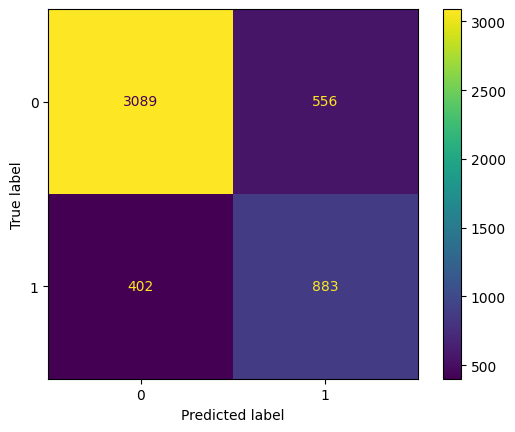

In [ ]:
# Melhor modelo
model_uri = f"runs:/{best_run_id}/model"
#model = mlflow.pyfunc.load_model(model_uri)
model = mlflow.sklearn.load_model(model_uri)

# Avaliações
y_pred_test = model.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)



---
Dessa vez, após o treinamento de novo modelo com o dataset ampliado obtivemos discreta melhora na acurácia geral (passou de 80% para 81%).

Houve ainda redução no viés, que passou a ser de 5%.


In [ ]:
# resultados no conjunto de treinamento
y_pred_train = model.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.81
Accuracy (TRAIN): 0.90
Viés: 0.05
Variância: 0.09


#### PFI

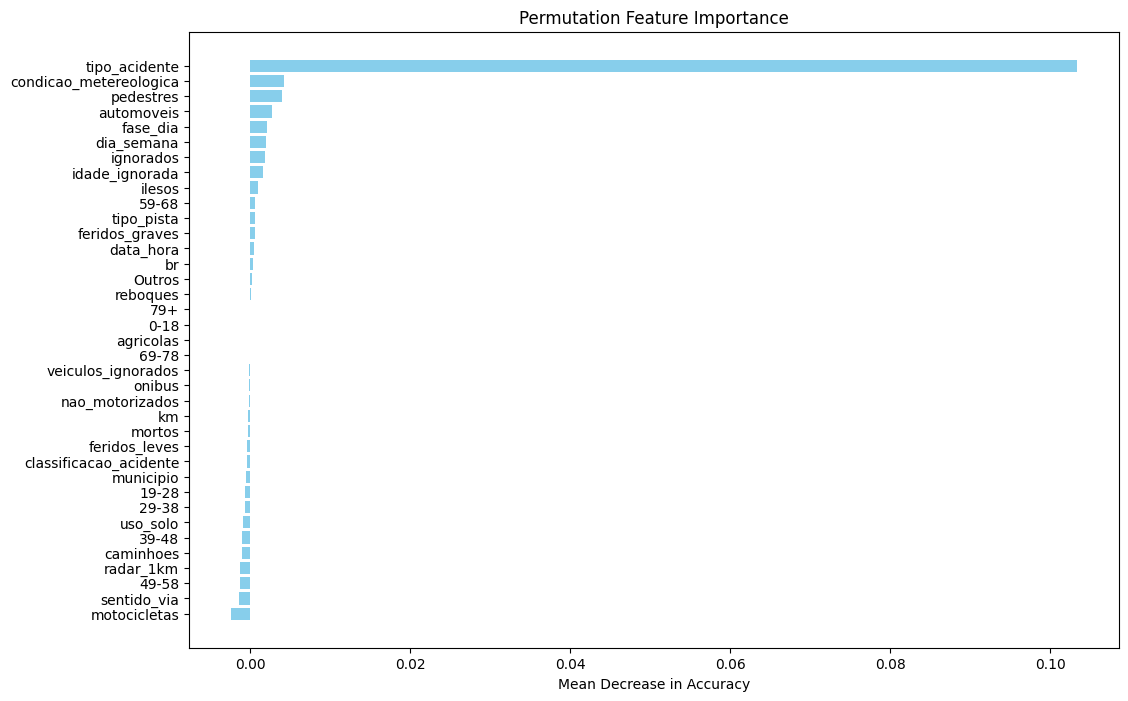

In [ ]:
# Calcular PFI
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=SEED, n_jobs=2)

# Extract the importance scores and feature names
feature_importances = result.importances_mean
feature_names = X_test.columns

# Create a DataFrame for easy plotting
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the Feature Importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()

In [ ]:
importances_df

,Feature,Importance
5,tipo_acidente,0.103300
9,condicao_metereologica,0.004199
35,pedestres,0.003969
19,automoveis,0.002684
7,fase_dia,0.002130
1,dia_semana,0.001961
16,ignorados,0.001765
34,idade_ignorada,0.001596
15,ilesos,0.000953
31,59-68,0.000636


### Bônus: Auto-sklearn

Experimentamos o auto-sklearn, mas a curácia geral obtida em seus melhores modelos não superou no Random Forest.

In [ ]:
!pip install scipy==1.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.4.26 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
jaxlib 0.4.26+cuda12.cudnn89 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.24.4 which is incompatible.


In [ ]:
!pip install Cython==0.29.35

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [ ]:
!pip install scikit-learn==0.24.2 --no-build-isolation

  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-0.24.2-cp310-cp310-linux_x86_64.whl size=22196178 sha256=15106e312ba60082e09f8983378cbd4d12be4edb38fa0e0c74ae34f52403d5b2
  Stored in directory: /root/.cache/pip/wheels/13/a4/68/4e78865652fa14db4a162b491e5138565f97646f9e1f2ab8cc
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.11.0 requires scikit-learn>=1.2.2, but you have scikit-learn 0.24.2 which is incompatible.
imbalanced-learn 0.10.1 requires scikit-learn>=1.0.2, but you have scikit-learn 0.24.2 which is incompatible.
mlxtend 0.22.0 requir

In [ ]:
!pip install auto-sklearn

  Using cached auto-sklearn-0.15.0.tar.gz (6.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for auto-sklearn: filename=auto_sklearn-0.15.0-py3-none-any.whl size=6641938 sha256=5b1bf56051b620b2ba2047cb22e3680cd5c4ffa1f61786fc4cafb19c42e57424
  Stored in directory: /root/.cache/pip/wheels/4d/0a/f9/8c1a06bcc36bc16b467b044b5bb03a90f92a5c5e6cd443414b
Successfully built auto-sklearn


In [ ]:
!pip install scikit-learn==1.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
auto-sklearn 0.15.0 requires scikit-learn<0.25.0,>=0.24.0, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
from autosklearn.classification import AutoSklearnClassifier
import autosklearn.metrics as metrics

In [ ]:
from sklearn.utils import resample

def balance_and_shuffle_data(X, y, seed):
    """
    Função para balancear e embaralhar dados usando oversampling.

    Parâmetros:
        X (pd.DataFrame): Features do dataset.
        y (pd.Series): Target do dataset.
        seed (int): Semente para o estado aleatório, garantindo reprodutibilidade.

    Retorna:
        X_balanced (pd.DataFrame): Features balanceadas e embaralhadas.
        y_balanced (pd.Series): Target balanceado e embaralhado.
    """
    # Concatenar X e y para manter a correspondência entre features e target
    data = pd.concat([X, y], axis=1)

    # Obter o número máximo de amostras em qualquer classe para balanceamento
    max_size = y.value_counts().max()

    # Lista para armazenar os dataframes balanceados
    lst = [data[data[y.name] == cls].sample(max_size, replace=True, random_state=seed) for cls in y.unique()]

    # Concatenar todos os dataframes balanceados
    data_balanced = pd.concat(lst)

    # Embaralhar os dados balanceados
    data_balanced = data_balanced.sample(frac=1, random_state=seed)

    # Separar X e y
    X_balanced = data_balanced.drop([y.name], axis=1)
    y_balanced = data_balanced[y.name]

    return X_balanced, y_balanced


In [ ]:
# Aplicar o oversampling ao conjunto de treinamento
X_train_balanced, y_train_balanced = balance_and_shuffle_data(X_train, y_train, SEED)
print("Distribuição das classes após o resampling (TREINAMENTO):")
print(np.bincount(y_train_balanced))

# Aplicar o oversampling ao conjunto de treinamento
X_val_balanced, y_val_balanced = balance_and_shuffle_data(X_val, y_val, SEED)
print("Distribuição das classes após o resampling (VALIDAÇÃO):")
print(np.bincount(y_val_balanced))

# Checar o balanceamento das classes no conjunto de teste
print("Distribuição das classes no conjunto de TESTE:")
print(np.bincount(y_test))

Distribuição das classes após o resampling (TREINAMENTO):
[7259 7259]
Distribuição das classes após o resampling (VALIDAÇÃO):
[3629 3629]
Distribuição das classes no conjunto de TESTE:
[3645 1285]


In [ ]:
# Configurar o auto-sklearn
automl = AutoSklearnClassifier(
    time_left_for_this_task=180,  # segundos
    per_run_time_limit=40,        # segundos por modelo
    #ensemble_size=1,
    #initial_configurations_via_metalearning=1,  # desativar meta-learning para começar do zero
    resampling_strategy='cv',
    resampling_strategy_arguments={'folds': 5},
    metric=metrics.accuracy
)

# Treinar o modelo
automl.fit(X_train_balanced, y_train_balanced)

automl.leaderboard()

[WARNING] [2024-07-07 19:25:41,064:Client-EnsembleBuilder] No runs were available to build an ensemble from


,rank,ensemble_weight,type,cost,duration
model_id,,,,,
7,1,0.84,lda,0.247486,7.619656
3,2,0.04,gaussian_nb,0.373950,4.549600
5,3,0.12,gaussian_nb,0.494214,5.759129


In [ ]:
print('Treino: ',automl.score(X_train_balanced,y_train_balanced))
print('Teste: ',automl.score(X_test,y_test))

Treino:  0.7564402810304449
Teste:  0.7210953346855984


In [ ]:
# Configurar o auto-sklearn
automl = AutoSklearnClassifier(
    time_left_for_this_task=300,  # segundos
    per_run_time_limit=40,        # segundos por modelo
    #ensemble_size=1,
    #initial_configurations_via_metalearning=1,  # desativar meta-learning para começar do zero
    resampling_strategy='cv',
    resampling_strategy_arguments={'folds': 5},
    metric=metrics.accuracy
)

# Treinar o modelo
automl.fit(X_train_balanced, y_train_balanced)

automl.leaderboard(detailed = True)

[WARNING] [2024-07-07 19:33:56,048:Client-EnsembleBuilder] No runs were available to build an ensemble from


,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
12,1,0.84,gradient_boosting,0.198099,20.707557,11,0.186458,0,1.720381e+09,1.720381e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
7,2,0.10,lda,0.247486,8.710400,6,0.246453,0,1.720381e+09,1.720381e+09,0.0,StatusType.SUCCESS,[],[liblinear_svc_preprocessor],weighting,Initial design
5,3,0.06,gaussian_nb,0.494214,5.235581,4,0.494507,0,1.720381e+09,1.720381e+09,0.0,StatusType.SUCCESS,[],[fast_ica],weighting,Initial design


In [ ]:
print('Treino: ',automl.score(X_train_balanced,y_train_balanced))
print('Teste: ',automl.score(X_test,y_test))

Treino:  0.8122330899572944
Teste:  0.777079107505071


AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:
Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      3645
           1       0.55      0.76      0.64      1285

    accuracy                           0.78      4930
   macro avg       0.73      0.77      0.74      4930
weighted avg       0.81      0.78      0.79      4930

Confusion Matrix:
[[2859  786]
 [ 313  972]]
Accuracy by class:
Class 0: 78.44%
Class 1: 75.64%


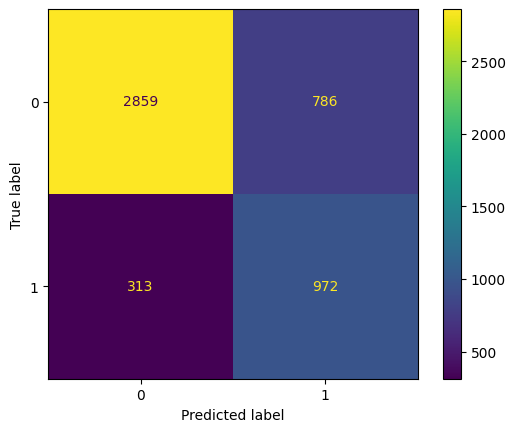

In [ ]:
# Avaliações
y_pred_test = automl.predict(X_test)

# Calculando a precisão
accuracy_test = accuracy_score(y_test, y_pred_test)
print("AVALIAÇÕES SOBRE O CONJUNTO DE TESTE:")
print(f"Accuracy: {accuracy_test:.2f}")

# Gerando o relatório de classificação
class_report = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(class_report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Cálculo da acurácia por classe
class_accuracy = 100 * conf_matrix.diagonal() / conf_matrix.sum(axis=1)
classes = np.unique(y_test)

# Exibir a acurácia por classe
print("Accuracy by class:")
for cls, acc in zip(classes, class_accuracy):
    print(f"Class {cls}: {acc:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

In [ ]:
# resultados no conjunto de treinamento
y_pred_train = automl.predict(X_train_balanced)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
accuracy_target = 0.95 # erro alvo de 5%

bias = accuracy_target - accuracy_train
if bias < 0: bias = 0

variance = accuracy_train - accuracy_test

print('VIÉS E VARIÂNCIA:')
print(f"Accuracy (TEST): {accuracy_test:.2f}")
print(f"Accuracy (TRAIN): {accuracy_train:.2f}")
print(f"Viés: {bias:.2f}")
print(f"Variância: {variance:.2f}")

VIÉS E VARIÂNCIA:
Accuracy (TEST): 0.78
Accuracy (TRAIN): 0.81
Viés: 0.14
Variância: 0.04
